#### Import Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.utils import resample
from scipy.optimize import least_squares
import pandas as pd
from sklearn.neighbors import KernelDensity
import sampyl as smp
from scipy.stats import norm, uniform
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from joblib import Parallel, delayed
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

#### Data Generation Process

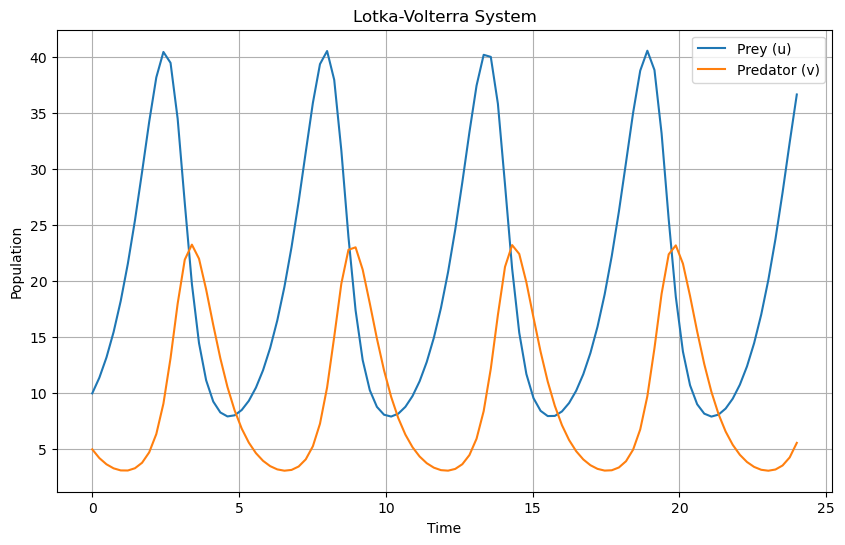

In [2]:
# Define the Lotka-Volterra system
def lotka_volterra_system(y, t, alpha, beta, gamma, delta):
    u, v = y
    du_dt = alpha * u - beta * u * v
    dv_dt = -gamma * v + delta * u * v
    return [du_dt, dv_dt]

# Parameters
alpha = 1.0
beta = 0.1
gamma = 1.5
delta = 0.075

# Initial conditions: u(0) = 10, v(0) = 5
y0 = [10, 5]

# Time points where we want the solution
time = np.linspace(0, 24, 100)

# Solve the system using odeint
solution = odeint(lotka_volterra_system, y0, time, args=(alpha, beta, gamma, delta))

# Extract u and v from the solution
u, v = solution.T

# Plot the solution
plt.figure(figsize=(10, 6))
plt.plot(time, u, label='Prey (u)')
plt.plot(time, v, label='Predator (v)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra System')
plt.legend()
plt.grid(True)
plt.show()

#### Class Creating Process

In [3]:
class DataPreprocessing:
    def __init__(self, data, num_samples=500, bootstrap=True, visualize=True, time=None):
        """
        Initializes the DataPreprocessing class with the given data and parameters.
        
        Parameters:
        data (np.ndarray): The input data matrix where each column represents a sample path.
        num_samples (int): The number of bootstrap samples to generate for each column.
        bootstrap (bool): Whether to perform bootstrapping. If False, checks data dimensions.
        visualize (bool): Whether to visualize the bootstrap paths. Default is True.
        time (np.ndarray, optional): Time array to use for plotting. Default is None.
        """
        self.data = self.confirm_data_structure(data)
        self.num_samples = num_samples
        self.bootstrap = bootstrap
        self.visualize = visualize
        self.time = self.confirm_time_length(time, self.data)
        self.bootstrap_paths = None

    def confirm_data_structure(self, data = None):
        """
        Confirms that the data is in the correct matrix structure, where rows represent time steps
        and columns represent state variables. If not, it transposes the data.
        
        Parameters:
        data (np.ndarray): The input data matrix.
        
        Returns:
        np.ndarray: The correctly structured data matrix.
        """
        if data is None:
            data = self.data
            
        if data.shape[0] < data.shape[1]:
            data = data.T
        return data

    def confirm_time_length(self, time_array = None, data_matrix = None, time_span=None):
        """
        Confirms that the length of the time array matches the number of rows in the data matrix.
        If not, it generates a new time array that spans the given time_span and fits the number of rows in the data.
        
        Parameters:
        time_array (np.ndarray): The input time array.
        data_matrix (np.ndarray): The input data matrix.
        time_span (tuple, optional): The start and end times for generating a new time array. 
                                     If None, it defaults to (time_array[0], time_array[-1]).
        
        Returns:
        np.ndarray: The confirmed or newly generated time array.
        """
        if data is None:
            data_matrix = self.data_matrix
             
        n_rows = data_matrix.shape[0]
        
        if time_array is None:
            return np.arange(n_rows)
        
        if time_span is None:
            time_span = (time_array[0], time_array[-1])
        
        if len(time_array) != n_rows:
            time_array = np.linspace(time_span[0], time_span[1], n_rows)
        
        return time_array

    def compute_library(self, data_matrix=None, library_type='polynomial', degree=2, 
                        custom_functions=None, specified_library=None, 
                        variable_names=None, include_interaction=True, 
                        include_intercept=True):
        """
        Compute the library of functions from the data.

        Parameters:
        data_matrix (np.ndarray): The input data matrix.
        library_type (str): The type of library to create ('polynomial', 'trigonometry', 'combination', 'custom', 'specified_library').
        degree (int): The degree of the polynomial or the trigonometric library.
        custom_functions (list, optional): A list of custom functions to apply for creating the library.
        specified_library (np.ndarray, optional): A precomputed library provided by the user.
        variable_names (list, optional): A list of variable names corresponding to the state variables.
        include_interaction (bool): Whether to include interaction terms in polynomial libraries.
        include_intercept (bool): Whether to include the intercept term (1) in the library.

        Returns:
        library (np.ndarray): The computed or specified library matrix (n by p).
        function_names (list): The list of function names in the library.
        """
        if data_matrix is None:
            data_matrix = self.data
        
        n, _ = data_matrix.shape
        
        if variable_names is None:
            variable_names = [f'x{i+1}' for i in range(data_matrix.shape[1])]
        
        if library_type == 'specified_library':
            if specified_library is None:
                raise ValueError("Specified library is None, but library_type is 'specified_library'. Please provide a specified library.")
            if specified_library.shape[0] != n:
                raise ValueError("Specified library must have the same number of rows as the data matrix.")
            if custom_functions is None:
                function_names = [f'f{i+1}' for i in range(specified_library.shape[1])]
            else:
                function_names = custom_functions
            
            library = specified_library

        elif library_type == 'custom':
            if custom_functions is None:
                raise ValueError("Custom functions must be provided when using 'custom' library type.")
            library_matrix = []
            function_names = []
            for func in custom_functions:
                transformed_data = np.apply_along_axis(func, 0, data_matrix)
                library_matrix.append(transformed_data)
                function_names.extend([f"{func.__name__}({var})" for var in variable_names])
            library = np.column_stack(library_matrix)

        else:
            if library_type == 'polynomial':
                library = ps.PolynomialLibrary(degree=degree, include_interaction=include_interaction, include_bias=include_intercept)
            elif library_type == 'trigonometry':
                library = ps.FourierLibrary(n_frequencies=degree)
            elif library_type == 'combination':
                library = ps.PolynomialLibrary(degree=degree, include_interaction=include_interaction, include_bias=include_intercept) + ps.FourierLibrary(n_frequencies=degree)
            else:
                raise ValueError("Invalid library type specified.")
            
            library_matrix = library.fit_transform(data_matrix)
            function_names = library.get_feature_names(input_features=variable_names)
            return library_matrix, function_names
        
        return library, function_names
        
    def compute_derivatives(self, data_matrix=None, true_parameter=None, 
                            library_matrix=None,
                            differentiation_method=ps.SmoothedFiniteDifference, 
                            smoother_kws=None, order=3, window_length=5):
        """
        Compute the derivatives of the observed data using a specified differentiation method.

        Parameters:
        data_matrix (np.ndarray): The input data matrix (n by m).
        true_parameter (np.ndarray, optional): The true parameters matrix (p by m).
        library_matrix (np.ndarray, optional): The library matrix (n by p). Required if true_parameter is given.
        differentiation_method (class): The differentiation method from pysindy. Default is SmoothedFiniteDifference.
            Other available differentiation methods include:
                - ps.FiniteDifference: Computes derivatives using finite differences.
                - ps.SpectralDerivative: Computes derivatives using spectral methods (FFT).
                - ps.SINDyDerivative: Learns the derivative using SINDy itself.
        smoother_kws (dict, optional): Keyword arguments for the smoother, if applicable.
        order (int): The differentiation order. Default is 3.
        window_length (int): The window length for smoothing. Default is 5.

        Returns:
        data_derivative_matrix (np.ndarray): The matrix of derivatives (n by m).
        """
        if data_matrix is None:
            data_matrix = self.confirm_data_structure(data)
        n, m = data_matrix.shape
        
        if true_parameter is not None:
            if library_matrix is None:
                library_matrix, function_names = self.compute_library(library_type='polynomial', degree=2,
                                                                      include_interaction=True, 
                                                                      include_intercept=True)
               
                print(f"Library matrix not provided, so we are using those computed from data with function names \n {function_names}\n")
            _, p = library_matrix.shape
            if true_parameter.shape != (p, m):
                raise ValueError("True parameter matrix must be of shape (number of library functions, number of state variables).")

        if smoother_kws is None:
            smoother_kws = {'window_length': window_length, 'polyorder': order}

        data_derivative_matrix = np.zeros((n, m))

        for i in range(m):
            if true_parameter is not None:
                def objective_function(params):
                    window_length, order = int(params[0]), int(params[1])
                    smoother_kws = {'window_length': window_length, 'polyorder': order}
                    differentiation_method_instance = differentiation_method(smoother_kws=smoother_kws)
                    derivative = differentiation_method_instance._differentiate(data_matrix[:, i], t=self.time)
                    prediction = np.dot(library_matrix, true_parameter[:, i])
                    # plt.plot(derivative, label = 'num approx')
                    # plt.plot(prediction, label = 'dot prod gen.')
                    # plt.legend()
                    # plt.show()
                    mse = np.mean((derivative - prediction) ** 2)
                    return mse

                res = minimize(objective_function, [window_length, order], bounds=[(3, 51), (1, 4)], method='Powell')
                optimal_window_length, optimal_order = int(res.x[0]), int(res.x[1])
                print(f'Learned best derivative hyperparameters for state variable {i}:\n (optimal_window_length, optimal_order) = {optimal_window_length, optimal_order}\n')
                smoother_kws = {'window_length': optimal_window_length, 'polyorder': optimal_order}
            else:
                optimal_window_length, optimal_order = window_length, order

            differentiation_method_instance = differentiation_method(smoother_kws=smoother_kws)
            data_derivative_matrix[:, i] = differentiation_method_instance._differentiate(data_matrix[:, i], t=self.time)
        # print(data_derivative_matrix-np.dot(library_matrix, true_parameter))
        return data_derivative_matrix

    def bootstrap_lotka_volterra_column(self, data_column, sample_ratio):
        """
        Bootstraps a single column of the Lotka-Volterra predator-prey population data.
        """
        n = len(data_column)
        indices = np.arange(1, n - 1)

        boot_indices = resample(indices, replace=False, n_samples=int(sample_ratio * len(indices)))
        boot_indices = np.sort(boot_indices)

        boot_indices = np.insert(boot_indices, 0, 0)
        boot_indices = np.append(boot_indices, n - 1)  # Add index n-1 at the end

        # Extract corresponding sampled data
        sampled_data = data_column[boot_indices]

        # Create new time points to interpolate to (original number of points)
        new_time_points = np.linspace(0, n - 1, n)

        # Interpolate sampled data to new time points
        interpolate_data = interp1d(boot_indices, sampled_data, kind='linear', fill_value="extrapolate")

        # Generate new interpolated data
        new_data_population = interpolate_data(new_time_points)

        return new_data_population

    def generate_bootstrap_paths(self, data=None, 
                                 data_derivative = None, 
                                 num_samples=None, 
                                 visualize=None, 
                                 data_mat_type = 'data_derivative_mat'):
        """
        Generates bootstrap paths for the input data matrix or checks dimensions if bootstrap is False.
        
        Returns:
        np.ndarray: A 3D array of shape (p, m, n) where p is the number of state variables,
                    n is the number of time instances, and m is the number of bootstrapped samples.
        """
        if data is None:
            data = self.confirm_data_structure(data)

        if data_derivative is None:
            data_derivative = self.compute_derivatives()
        
        if num_samples is None:
            num_samples = self.num_samples
        if visualize is None:
            visualize = self.visualize

        if data_mat_type == 'data_mat':
            data_matrix = data

        elif data_mat_type == 'data_derivative_mat':
            data_matrix = data_derivative

        n_rows, n_cols = data_matrix.shape

        if self.bootstrap:
            # Initialize the output array to hold bootstrap samples
            self.bootstrap_paths = np.zeros((n_cols, num_samples, n_rows))

            for col in range(n_cols):
                for i in range(num_samples):
                    # Randomly select the proportion of data points to use
                    sample_ratio = np.random.uniform(0.6, 0.95)

                    # Generate a bootstrap sample for the current column
                    self.bootstrap_paths[col, i, :] = self.bootstrap_lotka_volterra_column(data_matrix[:, col], sample_ratio)
                
            if visualize:
                self.visualize_bootstrap_paths()
            
            # Reorder dimensions to (p, m, n) where p is the number of state variables
            return self.bootstrap_paths
        else:
            # Check the dimensions if bootstrapping is not performed
            if n_cols > 1 and data_matrix.ndim != 3:
                raise ValueError("For multiple state variables, the data matrix should be 3D (p x m x n).")
            elif n_cols == 1 and data_matrix.ndim != 2:
                raise ValueError("For a single state variable, the data matrix should be 2D (p x n).")
            return data_matrix

    def visualize_bootstrap_paths(self, bootstrap_matrix=None, num_samples_to_plot=None, plot_original = False):
        """
        Visualizes the bootstrapped paths for each state variable.
        
        Parameters:
        bootstrap_matrix (np.ndarray, optional): The bootstrap paths matrix to visualize.
                                                 Defaults to the generated bootstrap paths.
        num_samples_to_plot (int, optional): The number of bootstrap samples to plot for each state variable.
                                             If None, all bootstrapped paths will be plotted.
        """
        if bootstrap_matrix is None:
            if self.bootstrap_paths is not None:
                bootstrap_matrix = self.bootstrap_paths
            else:
                raise ValueError("Bootstrap paths not generated. Please generate them first.")

        p, m, n = bootstrap_matrix.shape
        time_points = self.time if self.time is not None else np.arange(n)

        # If num_samples_to_plot is None, plot all bootstrapped paths
        num_samples_to_plot = m if num_samples_to_plot is None else min(num_samples_to_plot, m)

        for state_var in range(p):
            plt.figure(figsize=(10, 6))
            # Plot the bootstrapped paths
            for i in range(num_samples_to_plot):
                plt.plot(time_points, bootstrap_matrix[state_var, i, :], alpha=0.4, label=f'Bootstrap Sample {i+1}')
            
            if plot_original:
                # Plot the original data for reference
                plt.plot(time_points, self.data[:, state_var], 'k-', lw=2, label='Original Data')

            plt.xlabel('Time')
            plt.ylabel(f'State Variable {state_var + 1}')
            plt.title(f'Bootstrapped Paths for State Variable {state_var + 1}')
            plt.grid(True)
            plt.show()


class Generate_Prior_Distribution:
    def __init__(self, data_derivative, library_matrix, function_names=None, num_iter=5500, threshold_value=0.05):
        self.data_derivative = data_derivative
        self.library_matrix = library_matrix
        self.function_names = function_names
        self.num_iter = num_iter
        self.threshold_value = threshold_value
        self.m = data_derivative.shape[-1]  # Number of state variables
        self.p = library_matrix.shape[-1]  # Number of functions in the library

        if function_names is None:
            self.function_names = ['fx' + str(i+1) + str(j+1) for i in range(self.m) for j in range(self.p)]
        else:
            self.function_names = function_names

    def process_arrays(self, arr1, arr2, tolerance=None):
        if arr1.shape != arr2.shape:
            raise ValueError("Input arrays must have the same shape.")
        if tolerance is None:
            tolerance = np.max(np.abs(arr1 - arr2)) / 2

        arr1_copy = np.copy(arr1)
        arr2_copy = np.copy(arr2)

        for i in range(len(arr1)):
            if np.sign(arr1_copy[i]) != np.sign(arr2_copy[i]):
                arr1_copy[i] = 0
                arr2_copy[i] = 0
            elif abs(arr1_copy[i] - arr2_copy[i]) > tolerance:
                arr1_copy[i] = 0
                arr2_copy[i] = 0

        mean_array = (arr1_copy + arr2_copy) * 0.8
        return mean_array

    def derive_success_probabilities(self, prior_matrix, min_prob=0.8):
        std_devs = np.std(prior_matrix, axis=0)
        means = np.mean(prior_matrix, axis=0)
        max_std, min_std = np.max(std_devs), np.min(std_devs)

        success_probabilities = 1 - (std_devs - min_std) / (max_std - min_std) * (1 - min_prob)
        success_probabilities[np.abs(means) < 0.0001] = 0.05

        return success_probabilities

    def apply_spike_and_slab(self, prior_matrix, success_probabilities, slab_variance=0.0, k = 4):
        num_samples, num_params = prior_matrix.shape
        samples = np.zeros((num_samples * k, num_params))

        for i in range(num_samples):
            for j in range(k):
                mask = np.random.binomial(1, success_probabilities, num_params)
                slab = np.random.normal(prior_matrix[i], np.sqrt(slab_variance), num_params)
                samples[i * k + j] = mask * slab
        return samples

    def apply_regularized_horseshoe_with_success(self, prior_matrix, success_probabilities, horseshoe_scale=0.1):
        num_samples, num_params = prior_matrix.shape
        samples = np.zeros((num_samples * 10, num_params))

        for i in range(num_samples):
            for j in range(10):
                local_shrinkage = np.random.normal(1, horseshoe_scale * success_probabilities, num_params)
                global_shrinkage = np.random.normal(1, horseshoe_scale, 1)
                shrinkage_factors = global_shrinkage * local_shrinkage
                samples[i * 10 + j] = prior_matrix[i] * shrinkage_factors
        return samples

    def generate_samples_with_prior(self, prior_matrix, prior_type='spike_and_slab', success_probabilities=None, 
                                    slab_variance=0.005, horseshoe_scale=0.1, div_prior = False):
        if success_probabilities is None and prior_type == 'spike_and_slab':
            success_probabilities = self.derive_success_probabilities(prior_matrix)

        if prior_type == 'spike_and_slab':
            ss_prior_matrix = self.apply_spike_and_slab(prior_matrix, success_probabilities, slab_variance)
        elif prior_type == 'regularized_horseshoe':
            if success_probabilities is None:
                success_probabilities = np.ones(prior_matrix.shape[1])
            ss_prior_matrix = self.apply_regularized_horseshoe_with_success(prior_matrix, success_probabilities, horseshoe_scale)
        else:
            print(f"Invalid prior_type '{prior_type}' specified. Returning the original prior matrix.")
            ss_prior_matrix = prior_matrix

        if div_prior:
            divided_prior = []
            for i in range(self.m):
                divided_prior.append(ss_prior_matrix[:, (i*self.p) : ((i+1)*self.p)])
            return divided_prior

        else:
            return ss_prior_matrix

    def combine_matrices_and_compute_stats(self, matrix1, matrix2):
        if matrix1.shape[-1] != matrix2.shape[-1]:
            raise ValueError("Input matrices must have the same number of columns.")

        means1 = np.mean(matrix1, axis=0)
        means2 = np.mean(matrix2, axis=0)

        common_means = self.process_arrays(means1, means2)

        std_devs = np.zeros(common_means.shape)
        non_zero_mean_indices = common_means != 0

        if np.any(non_zero_mean_indices):
            combined_matrix_non_zero = np.concatenate((matrix1[:, non_zero_mean_indices], matrix2[:, non_zero_mean_indices]), axis=0)
            std_devs[non_zero_mean_indices] = np.std(combined_matrix_non_zero, axis=0)
            min_std = np.min(std_devs[non_zero_mean_indices])
            std_devs[~non_zero_mean_indices] = min_std / 10
        else:
            std_devs.fill(1e-10)

        return common_means, std_devs

    def learn_prior_distribution_single_state(self, dist_type='Normal'):
        Means_or_Lower = []
        Std_orUpper = []
        all_chain1 = []
        all_chain2 = []

        for i in range(self.m):
            data_derivative_vector = self.data_derivative[:, i]
            x0 = np.zeros(self.p)

            stls_solution = self.stls(x0, data_derivative_vector).round(3)

            num_samples = 50
            start_params = stls_solution
            start = {'params': start_params, 'sig': 0.1}

            def log_likelihood(params, sig):
                y_hat = self.compute_sampled_params(params)
                residuals = data_derivative_vector - y_hat
                model = smp.Model()
                model.add(smp.normal(residuals, mu=np.zeros(len(residuals)), sig=sig))
                model.add(smp.exponential(sig))
                return model()

            sampler = smp.NUTS(log_likelihood, start)
            chain1 = sampler.sample(num_samples, burn=int(0.2 * num_samples))

            num_samples = 5000
            start = {'params': np.zeros(self.p), 'sig': 0.1}
            sampler2 = smp.Slice(log_likelihood, start)
            chain2 = sampler2.sample(num_samples, burn=int(0.2 * num_samples))

            common_means, std_devs = self.combine_matrices_and_compute_stats(chain1['params'], chain2['params'])

            if dist_type == 'Normal':
                Means_or_Lower.append(common_means)
                Std_orUpper.append(std_devs * 3)
            elif dist_type == 'Uniform':
                Means_or_Lower.append(common_means - 8 * std_devs)
                Std_orUpper.append(common_means + 8 * std_devs)
            else:
                raise ValueError("Invalid Distribution type. Choose from 'Normal', or 'Uniform'.")

            all_chain1.append(chain1)
            all_chain2.append(chain2)
        return all_chain1, all_chain2, Means_or_Lower, Std_orUpper


    def learn_prior_distribution_all_state( self, data_derivative = None, library_matrix = None, function_names = None, 
                             dist_type='Normal', num_iter = None, threshold_value = None):
        if data_derivative is None:
            data_derivative = self.data_derivative
        if function_names is None:
            function_names = self.function_names
        if library_matrix is None:
            library_matrix = self.library_matrix
        if num_iter is None:
            num_iter = self.num_iter
        if threshold_value is None:
            threshold_value = self.threshold_value
            
        data_derivative_matrix = data_derivative
        
        m = data_derivative_matrix.shape[-1]  # Number of state variables
        p = library_matrix.shape[-1]  # Number of functions in the library
    
        if function_names is None:
            function_names = ['fx'+ str(i+1) + str(j+1) for i in range (m) for j in range(p)]
        # print(function_nm)
        
        # Define the loss function
        def lv_model_resid(params):
            params = np.array(params).reshape(m, p).T
            residuals = data_derivative_matrix - np.dot(library_matrix, params)
            return residuals.flatten()
        
        def compute_sampled_params(params):
            return np.dot(library_matrix, params)
        
        def log_likelihood(params, sigs):
            params = np.array(params).reshape(self.m, self.p).T
            y = self.data_derivative
            y_hat = compute_sampled_params(params)
            
            # Convert y and y_hat to standard NumPy arrays if they are not already
            y = np.array(y)
            y_hat = np.array(y_hat)
            
            model = smp.Model()
            
            # Adding the log-likelihood for each state variable
            for i in range(self.m):
                model.add(smp.normal(y[:, i], mu=y_hat[:, i], sig=sigs[i]))
            
            # Adding priors for each sigma
            for sig in sigs:
                model.add(smp.exponential(sig))
            
            return model()

            
        start_sigs = np.full(m,0.1)
        
        # Slice Learning
        num_samples = num_iter
        start_params = np.zeros(m * p)
        start = {'params': start_params, 'sigs': start_sigs}
        sampler2 = smp.Slice(log_likelihood, start)
        
        chain2 = sampler2.sample(num_samples, burn=int(0.2 * num_samples))
    
        
        # NUTS Learning
        def stls(lv_model_resid, x0, threshold=0.06, max_iter=20):
            params = x0.copy()
            for i in range(max_iter):
                results = least_squares(lv_model_resid, x0=params)
                params = results.x
                params[np.abs(params) < threshold] = 0
            return params
        
        x0 = np.zeros(m * p)
        stls_solution = stls(lv_model_resid, x0, threshold=threshold_value).round(3)
        
        zipped_results = list(zip(function_names * m, stls_solution))
        # print(zipped_results)
        
        num_samples = int(((num_iter + 3000)/100 - (num_iter/100))/2)
        start_params = stls_solution
        start_sigs = np.full(m, np.mean(chain2.sigs[-100:], 0))  # Initial sigmas for each state variable
        start = {'params': start_params, 'sigs': start_sigs}
        
        mcmc_method = 'nuts'
        if mcmc_method == 'slice':
            sampler = smp.Slice(log_likelihood, start)
        elif mcmc_method == 'nuts':
            sampler = smp.NUTS(log_likelihood, start)
        elif mcmc_method == 'hamiltonian':
            sampler = smp.Hamiltonian(log_likelihood, start)
        elif mcmc_method == 'metropolis':
            sampler = smp.Metropolis(log_likelihood, start)
        else:
            raise ValueError("Invalid MCMC method specified. Choose from 'slice', 'nuts', or 'metropolis'.")
        
        chain1 = sampler.sample(num_samples, burn=int(0.2 * num_samples))
        
        
        common_means, std_devs = self.combine_matrices_and_compute_stats(chain1['params'], chain2['params'])
        
        if dist_type == 'Normal':
            return chain1, chain2, common_means, std_devs * 3
        elif dist_type == 'Uniform':
            return chain1, chain2, common_means - 8 * std_devs, common_means + 8 * std_devs
        else:
            raise ValueError("Invalid Distribution type. Choose from 'Normal', or 'Uniform'.")

    def generate_samples(self, dist_type, num_samples, param1, param2):
        if dist_type == 'Normal':
            if isinstance(param1, np.ndarray) or isinstance(param2, np.ndarray):
                return np.random.normal(loc=param1, scale=param2, size=(num_samples, len(param1)))
            else:
                return np.random.normal(loc=param1, scale=param2, size=num_samples)
        elif dist_type == 'Uniform':
            if isinstance(param1, np.ndarray) or isinstance(param2, np.ndarray):
                return np.random.uniform(low=param1, high=param2, size=(num_samples, len(param1)))
            else:
                return np.random.uniform(low=param1, high=param2, size=num_samples)
        else:
            raise ValueError("Invalid distribution type. Choose from 'Normal' or 'Uniform'.")


    def generate_prior_distributions(self, dist_type='Normal', prior_type = 'spike_and_slab',slab_variance = 0.01,horseshoe_scale = 0.1, return_chains = False ):
        chain1, chain2, means, std_devs = self.learn_prior_distribution_all_state(dist_type=dist_type)

        prior_matrix = self.generate_samples(dist_type=dist_type, 
                                             num_samples=10000, 
                                             param1=means, 
                                             param2=std_devs).round(3)
        if prior_type is not None:
            ss_prior_matrix = self.generate_samples_with_prior(prior_matrix, prior_type=prior_type,
                                                           success_probabilities=None, slab_variance=slab_variance,
                                                           horseshoe_scale=horseshoe_scale)
       
        else:
            ss_prior_matrix= prior_matrix

        divided_prior = []
        for i in range(self.m):
            # print((i*self.p), ((i+1)*self.p))
            divided_prior.append(ss_prior_matrix[:, (i*self.p) : ((i+1)*self.p)])
        if return_chains:
            return chain1, chain2, divided_prior
        else:
            return divided_prior


from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np

#data_matrix, prior_matrix, time_array, function_names, 
class SIP_Learning:
    def __init__(self, library_matrix, bootstrap_paths, prior_generator, dim=5, i=0):
        """
        Initializes the SIP_Learning class with the given data and parameters.
        
        Parameters:
        data_matrix (np.ndarray): The input data matrix where each column represents a sample path.
        prior_matrix (np.ndarray): The prior matrix for parameter sampling.
        time_array (np.ndarray): The time array corresponding to the data matrix.
        library_matrix (np.ndarray): The library_matrix of functions generated for the data.
        bootstrap_paths (np.ndarray): The bootstrapped data paths.
        function_names (list): The names of the functions in the library_matrix.
        dim (int): The number of dimensions to use in KDE and other operations. Default is 5.
        """
        # self.data_matrix = data_matrix
        # self.time_array = time_array
        # self.function_names = function_names
        # self.prior_matrix = prior_matrix
        
        self.library_matrix = library_matrix
        self.prior_generator = prior_generator
        self.i = i
        self.bootstrap_paths = bootstrap_paths[self.i]
        self.dim = dim
        
    def equally_spaced_elements(self, n, array):
        # print(array.shape, n)
        p = array.shape[-1]
        if p <= n:
            print (f"The length of the array p = {p} is less than n = {n} so we chose n = p.")
            n = p
            
        indices = np.linspace(0, p - 1, n, dtype=int)
        if array.ndim == 1:
            array = array.reshape(1, -1)
        if np.any(indices >= array.shape[1]):
            raise ValueError("Some indices are out of bounds for the given array.")
        extracted_elements = array[:, indices]
        return extracted_elements, indices

    def fit_kde(self, y_paths=None, bw_method='scott', dim=None, idx=False, optimize_bandwidth=True, kernel='gaussian'):
        """
        Estimates a kernel density estimate (KDE) for a given 2D array of observations where each row is a random variable.
        
        Parameters:
        y_paths (np.ndarray): The array of observed paths.
        bw_method (str or float): The bandwidth method for the KDE. Default is 'scott'.
        dim (int): The number of dimensions to use in the KDE estimation. Default is 5.
        idx (bool): Whether to return the indices of the elements used in the KDE. Default is False.
        optimize_bandwidth (bool): Whether to optimize bandwidth using cross-validation. Default is False.
        kernel (str): The kernel to use for KDE. Options are 'gaussian', 'tophat', 'epanechnikov', etc.
        
        Returns:
        kde (KernelDensity): The estimated kernel density object.
        indices (np.ndarray, optional): The indices of the elements used in the KDE, if idx is True.
        """
        if dim is None:
            dim = self.dim
        if y_paths is None:
            y_paths = self.bootstrap_paths
        data, indices = self.equally_spaced_elements(dim, y_paths)

        if optimize_bandwidth:
            # Use GridSearchCV to find the best bandwidth
            grid = GridSearchCV(KernelDensity(kernel=kernel),
                                {'bandwidth': np.logspace(-1, 1, 20)},
                                cv=5)  # 5-fold cross-validation
            grid.fit(data)
            best_bandwidth = grid.best_params_['bandwidth']
            kde = KernelDensity(bandwidth=best_bandwidth, kernel=kernel)
            # print(f"Optimal bandwidth: {best_bandwidth}")
            bw_method = best_bandwidth
        else:
            kde = KernelDensity(bandwidth=bw_method, kernel=kernel)
        
        kde.fit(data)
        # self.bw_method = bw_method
        if idx:
            return kde, indices
        else:
            return kde, bw_method

    def compute_density_values(self, points, kde=None, dim=None, batch_size=5000, n_jobs=4):
        if dim is None:
            dim = self.dim
        if kde is None:
            kde = self.fit_kde()
        
        # Define a helper function to process a batch of points
        def process_batch(batch_points):
            eval_points, _ = self.equally_spaced_elements(dim, batch_points)
            log_densities = kde.score_samples(eval_points)
            return np.exp(log_densities)
        
        # Split the points into batches
        num_batches = len(points) // batch_size + (len(points) % batch_size > 0)
        
        # Process each batch in parallel
        densities = np.concatenate(
            Parallel(n_jobs=n_jobs)(delayed(process_batch)(points[i*batch_size:(i+1)*batch_size]) for i in range(num_batches))
        )
        
        return densities

    def rejection_sampling(self, samples_from_prior, kde_obs, Q=None):
        if Q is None:
            Q = self.Q
            
        _, bw_method = sip_learning.fit_kde()
        # Generate pushforward samples from prior
        push_prior = Q(samples_from_prior, self.library_matrix)
        
        # Fit KDE for the prior pushforward
        kde_prior, _ = self.fit_kde(push_prior, bw_method=bw_method, dim=None, 
                                 idx=False, optimize_bandwidth=False, kernel='gaussian')
        
        # Calculate r values for all samples in the batch
        kde_obs_pprior = self.compute_density_values(push_prior, kde_obs, dim=None)
        kde_prior_pprior = self.compute_density_values(push_prior, kde_prior, dim=None)
        r_values_ = kde_obs_pprior / kde_prior_pprior
        M = np.max(r_values_)
        r_values = r_values_/M
    
        # Generate uniform random values
        uniform_sets = np.random.uniform(0, 1, len(r_values))
    
        # Compute the difference
        diff = r_values - uniform_sets
    
        # Accept samples where diff >= 0
        accepted_samples = samples_from_prior[diff >= 0]
        
        # print(f'{len(accepted_samples)} was accepted out of {len(samples_from_prior)} total prior samples')
        return accepted_samples

    def kl_divergence(self, p = None, q = None, bandwidth=1.0):
        if p is None:
            p = self.bootstrap_paths

        if q is None:
            raise ValueError(" You need to provide the distribution matrix q")
        kde_p = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(p)
        kde_q = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(q)

        points = kde_p.sample(n_samples=200)

        log_p_x = kde_p.score_samples(points)
        log_q_x = kde_q.score_samples(points)

        kl_p_q = np.sum(np.exp(log_p_x) * (log_p_x - log_q_x)) / points.shape[0]
        kl_q_p = np.sum(np.exp(log_q_x) * (log_q_x - log_p_x)) / points.shape[0]
        return kl_p_q, kl_q_p

    def integrate_prior_generator(self, prior_generator):
        """
        Integrate the prior generator into the class to provide priors dynamically.
        
        Parameters:
        prior_generator (Generate_Prior_Distribution): The prior generator instance.
        """
        self.prior_generator = prior_generator

    def generate_posterior_samples(self, num_posterior_samples=50, kde_obs=None, prior_generator=None, Q=None):
        if Q is None:
            Q = self.Q
        if kde_obs is None:
            kde_obs = self.fit_kde()
            
        if prior_generator is None:
            prior_generator = self.prior_generator
            
        if prior_generator is None:
            raise ValueError("A prior generator must be provided.")

        # chain1, chain2, samples_from_prior_ = prior_generator.generate_prior_distributions(dist_type='Normal',
        #                                                                                prior_type = 'spike_and_slab',
        #                                                                                return_chains = True)
        chain1, chain2, means, stds = prior_generator.learn_prior_distribution_all_state(dist_type='Normal')
            
        x_post_param_samples = []
        tym = 0
        with tqdm(total=num_posterior_samples) as pbar:
            while len(x_post_param_samples) < num_posterior_samples:
                if len(x_post_param_samples) < 30:                    
                    prior_matrix = self.generate_samples(dist_type='Normal', 
                                             num_samples=2000, 
                                             param1=means,
                                             param2=stds)
                    
                    samples_from_prior_ = prior_generator.generate_samples_with_prior(prior_matrix, 
                                                                                      prior_type='spike_and_slab',
                                                                                      div_prior = True
                                                                                     )
                    # print(len(samples_from_prior_))
                    samples_from_prior = samples_from_prior_[self.i]
                    # print(samples_from_prior.shape)
                else:
                    x_prior_param_low = np.min(x_post_param_samples, 0)
                    x_prior_param_high = np.max(x_post_param_samples, 0)
                    samples_from_prior = self.generate_samples(dist_type='Uniform', 
                                                               num_samples=1000, 
                                                               param1=x_prior_param_low,
                                                               param2=x_prior_param_high)
                    
                    # print(f'low: {x_prior_param_low}, high: {x_prior_param_high}\n')
        
                accepted_samples = self.rejection_sampling(samples_from_prior, kde_obs, Q)
                x_post_param_samples.extend(accepted_samples)
                if tym%10 == 0:
                    print(f'at tym = {tym}, total samples accepted = {len(x_post_param_samples)} \n')
                tym += 1
        print(f"Final total number of accepted samples = {len(x_post_param_samples)}")
        return np.array(x_post_param_samples)

    # Define the simulate_param and Q functions as provided:
    def simulate_param(self, params, library_matrix = None):
        if library_matrix is None:
            library_matrix = self.library_matrix
        params = np.array(params).reshape(-1,1)
        return np.dot(library_matrix, params).reshape(-1)
    
    def Q(self, prior_param_samples, library_matrix = None):
        if library_matrix is None:
            library_matrix = self.library_matrix
        pushforward = [self.simulate_param(param, library_matrix) for param in prior_param_samples]
        # pushforward = [self.simulate_param(param, library_matrix) for param in tqdm(prior_param_samples, desc="Simulating Parameters")]
        return np.array(pushforward)

    def generate_samples(self, dist_type, num_samples, param1, param2):
        """
        Generate samples from either a normal or uniform distribution.
        
        Parameters:
        dist_type (str): The type of distribution ('Normal' or 'Uniform').
        num_samples (int): The number of samples to generate.
        param1 (float or np.ndarray): For 'Normal', this is the mean. For 'Uniform', this is the lower bound.
        param2 (float or np.ndarray): For 'Normal', this is the standard deviation. For 'Uniform', this is the upper bound.
        
        Returns:
        np.ndarray: An array of generated samples.
        """
        if dist_type == 'Normal':
            return np.random.normal(loc=param1, scale=param2, size=(num_samples, len(param1)))
        elif dist_type == 'Uniform':
            return np.random.uniform(low=param1, high=param2, size=(num_samples, len(param1)))
        else:
            raise ValueError("Invalid distribution type. Choose from 'Normal' or 'Uniform'.")    

#### Real Analysis

Learned best derivative hyperparameters for state variable 0:
 (optimal_window_length, optimal_order) = (5, 3)

Learned best derivative hyperparameters for state variable 1:
 (optimal_window_length, optimal_order) = (5, 3)



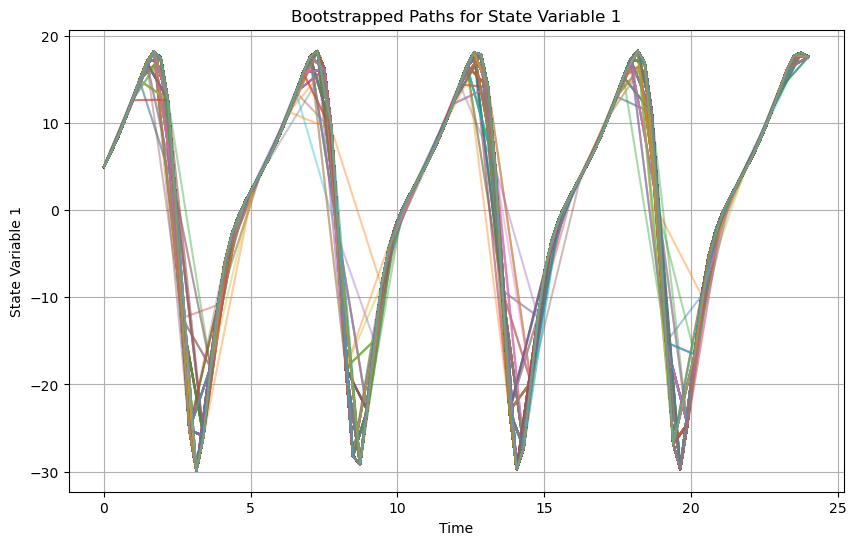

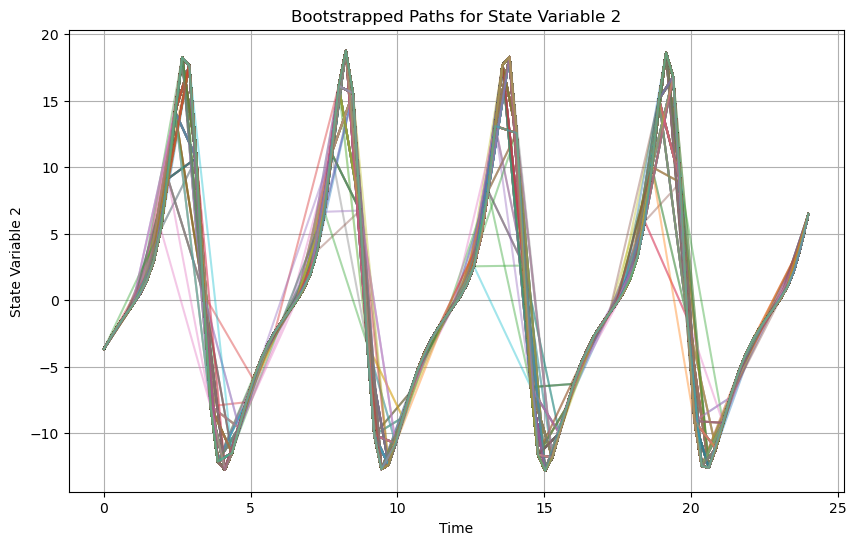

(2, 500, 100) 
 ['1', 'u', 'v', 'u^2', 'u v', 'v^2']
Progress: [##############################] 8000 of 8000 samples
Progress: [##############################] 15 of 15 samples


In [4]:
# Using the Preprocessing Class (# Just Passing in the data and then runnning the algorithm using default)
data = np.vstack((u,v)).T
# True Parameters
true_params = np.array([[0,1,0,0,-0.1,0], [0,0,-1.5, 0, 0.075, 0]]).T

# Using the Preprocessing Class
#Initialize a data_preprocessing class
data_preprocessing = DataPreprocessing(data, 
                                       num_samples=500, 
                                       bootstrap=True, 
                                       visualize=True, 
                                       time=time)
# Generate a library matrix
library_matrix, function_names = data_preprocessing.compute_library(library_type='polynomial',
                                                                    variable_names = ('u', 'v'), 
                                                                    degree=2)
# Generate a data derivative matrix
data_derivative = data_preprocessing.compute_derivatives(true_parameter=true_params, 
                                                         library_matrix = library_matrix)
# Generate bootstrap data matrix
bootstrap_paths = data_preprocessing.generate_bootstrap_paths(data_derivative = data_derivative,
                                                              data_mat_type = 'data_derivative_mat')

# Check the shape of the bootstrap paths (should be p, m, n)
print(bootstrap_paths.shape, '\n', function_names) 

# Generate Priors for the dataset:
prior_generator = Generate_Prior_Distribution(data_derivative, 
                                              library_matrix, 
                                              function_names=function_names, 
                                              num_iter=8000, 
                                              threshold_value=0.05)
chain1, chain2, prior_matrix = prior_generator.generate_prior_distributions(dist_type='Normal',
                                                                            prior_type = 'spike_and_slab', 
                                                                            return_chains = True)


In [5]:
Library_matrix = library_matrix

#### Learning Posterior Distribution

In [6]:
%%time
# Create the prior generator instance
prior_generator = Generate_Prior_Distribution(data_derivative, 
                                              library_matrix, 
                                              function_names=function_names, 
                                              num_iter=8500, threshold_value=0.05)

Posterior_samples = []
Push_posterior_samples = []
for i in range(data.shape[-1]):
    
    # Create the SIP_Learning instance
    sip_learning = SIP_Learning(library_matrix, bootstrap_paths, prior_generator, dim=10, i=i)
    
    # Fit KDE to the observed data
    kde_obs, bw_method = sip_learning.fit_kde()
    
    # Generate posterior samples
    posterior_samples = sip_learning.generate_posterior_samples(num_posterior_samples=50, 
                                                                kde_obs=kde_obs, 
                                                                prior_generator=prior_generator)
    
    # Now you can analyze the posterior samples
    print("Posterior samples generated:", posterior_samples.round(3))
    
    # Calculate KL divergence between the observed and posterior distributions
    push_posterior = sip_learning.Q(posterior_samples)
    push_posterior.shape
    
    kl_p_q, kl_q_p = sip_learning.kl_divergence(bootstrap_paths[i], push_posterior, bandwidth=0.15)
    print(f"KL divergence from p to q: {kl_p_q}, from q to p: {kl_q_p}")

    Posterior_samples.append(posterior_samples)
    Push_posterior_samples.append(push_posterior)

Progress: [##############################] 8500 of 8500 samples
Progress: [############------------------] 6 of 15 samples

C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Progress: [##############################] 15 of 15 samples


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

at tym = 0, total samples accepted = 1 

at tym = 10, total samples accepted = 11 

at tym = 20, total samples accepted = 21 

at tym = 30, total samples accepted = 31 

at tym = 40, total samples accepted = 47 



  0%|                                                                                           | 0/50 [03:13<?, ?it/s]


Final total number of accepted samples = 51
Posterior samples generated: [[-0.     1.043  0.     0.    -0.106 -0.   ]
 [-0.     0.985  0.     0.    -0.102 -0.   ]
 [ 0.     1.073  0.     0.    -0.109 -0.   ]
 [-0.     1.09   0.     0.    -0.113  0.   ]
 [-0.     1.008  0.     0.    -0.106 -0.   ]
 [-0.     1.105  0.    -0.    -0.113  0.   ]
 [-0.     1.099  0.     0.    -0.116 -0.   ]
 [ 0.     1.04   0.     0.    -0.107  0.   ]
 [-0.     1.105  0.    -0.    -0.115  0.   ]
 [-0.     1.083  0.     0.    -0.109 -0.   ]
 [-0.     1.03   0.167 -0.    -0.111  0.   ]
 [-0.     1.003  0.     0.    -0.098 -0.   ]
 [-0.     1.007  0.     0.    -0.101  0.   ]
 [-0.     1.127  0.    -0.    -0.115  0.   ]
 [ 0.     0.954  0.     0.    -0.094  0.   ]
 [-0.     1.033  0.     0.    -0.108  0.   ]
 [ 0.     1.019  0.    -0.    -0.103  0.   ]
 [ 0.     1.14   0.    -0.    -0.119 -0.   ]
 [-0.     1.052  0.     0.    -0.112 -0.   ]
 [ 0.     1.093  0.    -0.    -0.114 -0.   ]
 [-0.     1.02   0.     0. 

C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Progress: [##############################] 15 of 15 samples


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

at tym = 0, total samples accepted = 1 

at tym = 10, total samples accepted = 14 

at tym = 20, total samples accepted = 29 

at tym = 30, total samples accepted = 49 



  0%|                                                                                           | 0/50 [02:46<?, ?it/s]

Final total number of accepted samples = 50
Posterior samples generated: [[ 0.000e+00 -0.000e+00 -1.578e+00  0.000e+00  7.600e-02 -0.000e+00]
 [-0.000e+00 -0.000e+00 -1.544e+00 -0.000e+00  7.500e-02 -0.000e+00]
 [-0.000e+00 -0.000e+00 -1.454e+00  0.000e+00  7.200e-02 -0.000e+00]
 [-0.000e+00 -0.000e+00 -1.482e+00  0.000e+00  7.400e-02  0.000e+00]
 [ 0.000e+00 -1.250e-01 -1.174e+00 -0.000e+00  9.100e-02 -5.300e-02]
 [-0.000e+00 -9.000e-03 -1.438e+00 -0.000e+00  7.300e-02 -0.000e+00]
 [-0.000e+00  2.600e-02 -1.520e+00  0.000e+00  7.100e-02 -0.000e+00]
 [ 0.000e+00 -0.000e+00 -1.478e+00  0.000e+00  7.200e-02  0.000e+00]
 [-0.000e+00 -0.000e+00 -1.529e+00  0.000e+00  7.500e-02  0.000e+00]
 [ 0.000e+00  2.300e-02 -1.449e+00 -0.000e+00  7.100e-02  0.000e+00]
 [-0.000e+00 -6.000e-03 -1.584e+00  0.000e+00  7.800e-02 -0.000e+00]
 [ 0.000e+00 -0.000e+00 -1.475e+00 -0.000e+00  7.300e-02  0.000e+00]
 [ 0.000e+00 -0.000e+00 -1.451e+00 -0.000e+00  7.300e-02  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.390

In [7]:
np.mean(posterior_samples, 0).round(3), np.std(posterior_samples, 0).round(3)

(array([ 0.02 , -0.016, -1.423,  0.   ,  0.078, -0.014]),
 array([0.028, 0.034, 0.124, 0.   , 0.005, 0.018]))

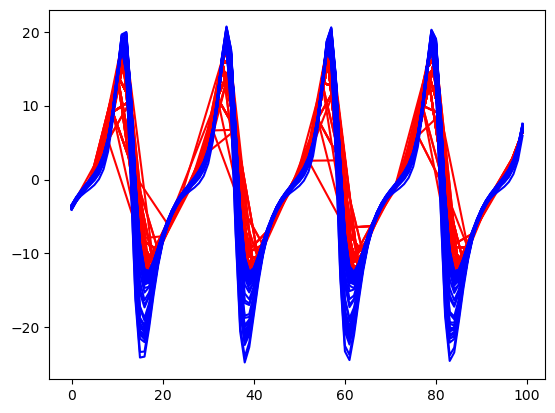

In [8]:
plt.plot(bootstrap_paths[i].T, color = 'red')
plt.plot(push_posterior[:].T, color = 'blue')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def generate_physics_expression(distribution, function_names, variable_name, threshold=0.01):
    """
    Generates the physics expression based on the mean coefficients from the parameter distribution matrix.

    Parameters:
    distribution (np.ndarray): The n by p matrix of recovered parameters.
    function_names (list): The names of the functions in the library.
    variable_name (str): The variable name (e.g., 'u').
    threshold (float): The threshold below which the mean coefficients are set to zero.

    Returns:
    str: The generated physics expression.
    """
    means = np.mean(distribution, axis=0)
    stds = np.std(distribution, axis=0)

    # Thresholding the means
    means[np.abs(means) < threshold] = 0

    # Constructing the expression
    expression_terms = []
    for mean, function_name in zip(means, function_names):
        if mean != 0:
            expression_terms.append(f"{mean:.3f} * {function_name}")

    expression = f"{variable_name} = " + " + ".join(expression_terms) if expression_terms else f"{variable_name} = 0"
    
    return expression, means, stds

def plot_parameter_distributions(distribution, function_names, means, variable_name):
    """
    Plots the KDE of each column in the distribution matrix. Columns with zero mean are plotted as a dashed line at zero.

    Parameters:
    distribution (np.ndarray): The n by p matrix of recovered parameters.
    function_names (list): The names of the functions in the library.
    means (np.ndarray): The thresholded means of the distribution matrix.
    variable_name (str): The variable name (e.g., 'u').
    """
    num_columns = distribution.shape[1]
    
    plt.figure(figsize=(3, num_columns * 2))
    
    for i in range(num_columns):
        plt.subplot(num_columns, 1, i + 1)
        
        if means[i] != 0:
            kde = gaussian_kde(distribution[:, i])
            min_, max_ = np.min(distribution[:, i]), np.max(distribution[:, i])
            tmp_val =np.max(np.abs([min_, max_]))/10
            # print(tmp_val)
            x = np.linspace(min_-tmp_val, max_+tmp_val, 1000)
            y = kde(x)
            plt.plot(x, y, label=f"{function_names[i]}", color = 'red')
            plt.fill_between(x, y, alpha=0.5,  color='orange')  # Fill under the curve
            plt.axvline(means[i], color='red', linestyle='--', alpha = 0.3)
        else:
            plt.axvline(0, color='red', linestyle='--', label=f"{function_names[i]}")
            plt.xlim(-0.1, 0.1)
        
        plt.ylabel('Density')
        plt.xlabel('Parameter Value')
        plt.title(f"Distribution of {function_names[i]} for {variable_name}")
        plt.legend()

    plt.tight_layout()
    plt.show()



def plot_parameter_distributions_v2(distribution, function_names, means, variable_name):
    """
    Plots the KDE of each column in the distribution matrix. Columns with zero mean are plotted as a dashed line at zero.
    If the mean is zero, the distribution is shifted to have zero mean before plotting the KDE.

    Parameters:
    distribution (np.ndarray): The n by p matrix of recovered parameters.
    function_names (list): The names of the functions in the library.
    means (np.ndarray): The thresholded means of the distribution matrix.
    variable_name (str): The variable name (e.g., 'u').
    """
    num_columns = distribution.shape[1]
    
    plt.figure(figsize=(3, num_columns * 2))
    
    for i in range(num_columns):
        plt.subplot(num_columns, 1, i + 1)
        
        if means[i] == 0:
            # Shift the distribution to have a zero mean
            shifted_data = distribution[:, i] - np.mean(distribution[:, i])
            
            # Check if the data variance is non-zero
            if np.var(shifted_data) > 0:
                kde = gaussian_kde(shifted_data)
                min_, max_ = np.min(shifted_data), np.max(shifted_data)
            else:
                # Handle case where data variance is zero (all values are the same)
                min_, max_ = np.min(shifted_data), np.max(shifted_data)
                kde = None
        else:
            kde = gaussian_kde(distribution[:, i])
            min_, max_ = np.min(distribution[:, i]), np.max(distribution[:, i])
        
        # Determine x-axis limits
        tmp_val = np.max(np.abs([min_, max_])) / 10
        x = np.linspace(min_ - tmp_val, max_ + tmp_val, 1000)
        
        # Plot the KDE and the vertical line
        if kde:
            y = kde(x)
            plt.plot(x, y, label=f"{function_names[i]}", color='red')
            plt.fill_between(x, y, alpha=0.5, color='orange')  # Fill under the curve
        
        plt.axvline(means[i] if means[i] != 0 else 0, color='red', linestyle='--', alpha=0.3)
        plt.xlim(min_ - tmp_val, max_ + tmp_val)
        
        plt.ylabel('Density')
        plt.xlabel('Parameter Value')
        plt.title(f"Distribution of {function_names[i]} for {variable_name}")
        plt.legend()

    plt.tight_layout()
    plt.show()


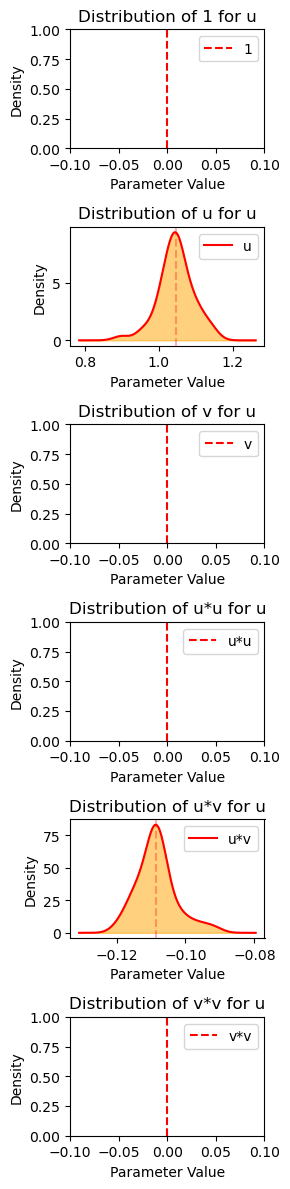

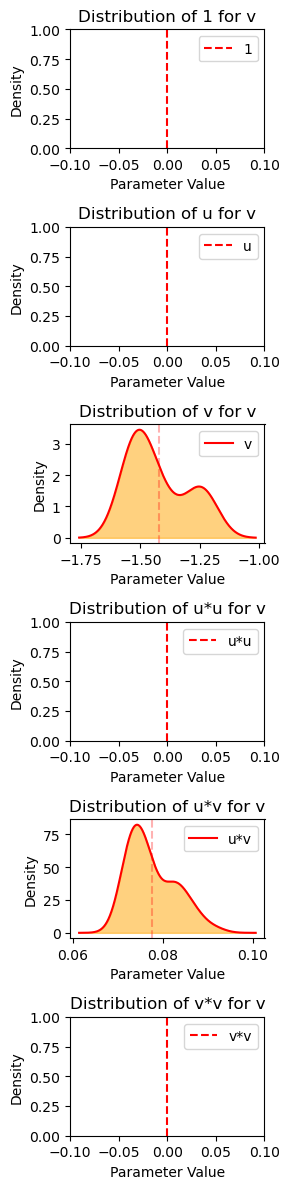




u = 1.046 * u + -0.108 * u*v
v = -1.423 * v + 0.078 * u*v


In [15]:
variable_names = ['u', 'v']
Expressions = []
threshold = 0.04

for i in range(len(Posterior_samples)):

    expressions, means_dict, stds_dict = generate_physics_expression(Posterior_samples[i], function_names, 
                                                          variable_name = variable_names[i], threshold=threshold)
    Expressions.append(expressions)
    
    plot_parameter_distributions(Posterior_samples[i], function_names, means_dict, variable_name= variable_names[i])
    print(f'\n\n')
    

for expression in Expressions:
    print(expression)

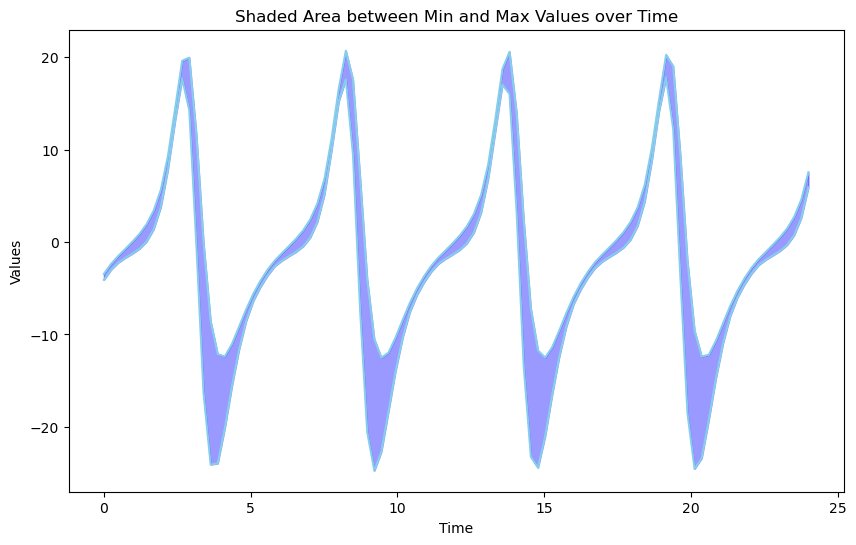

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fill_between_min_max(matrix, time_array=None):
    """
    Plots a shaded region between the minimum and maximum values of each column in the matrix
    with time_array as the x-axis.

    Parameters:
    matrix (np.ndarray): The n by m matrix where each column corresponds to values at a specific time.
    time_array (np.ndarray): The time array of length m.
    """
    if time_array is None:
        time_array = np.arange(matrix.shape[1])
    
    # Ensure matrix and time_array dimensions are compatible
    if matrix.shape[1] != len(time_array):
        raise ValueError("The number of columns in the matrix must match the length of the time array.")
    
    # Calculate min and max for each column
    min_val_array = np.min(matrix, axis=0)
    max_val_array = np.max(matrix, axis=0)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.fill_between(time_array, min_val_array, max_val_array, color='blue', alpha=0.4)
    plt.plot(time_array, min_val_array, color='skyblue', label='Min values')
    plt.plot(time_array, max_val_array, color='skyblue', label='Max values')
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Shaded Area between Min and Max Values over Time')
    # plt.legend()
    # plt.grid(True)
    plt.show()

plot_fill_between_min_max(Push_posterior_samples[1], time)


In [13]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import gaussian_kde

def threshold_matrices(matrices, threshold):
    """
    Apply thresholding to the matrices. If the absolute mean of a column is below the threshold,
    replace the entire column with zeros.

    Parameters:
    matrices (list of np.ndarray): List of matrices with dimensions n_p x m.
    threshold (float): The threshold value to determine whether to zero out a column.

    Returns:
    list of np.ndarray: Thresholded matrices.
    """
    thresholded_matrices = []
    for matrix in matrices:
        matrix_copy = matrix.copy()  # Make a copy to avoid changing the original matrix
        means = np.mean(matrix_copy, axis=0)
        mask = np.abs(means) < threshold
        matrix_copy[:, mask] = 0
        thresholded_matrices.append(matrix_copy)
    return thresholded_matrices

def extract_state_variables(final_expressions):
    """
    Extract state variables from final expressions.

    Parameters:
    final_expressions (list of str): List of final expressions.

    Returns:
    list of str: List of state variables.
    """
    return [expr.split('=')[0].strip() for expr in final_expressions]

def system_function(y, t, coefficients, function_names, var_name):
    """
    Define the system of ODEs.

    Parameters:
    y (list): State variables.
    t (float): Time.
    coefficients (list): Coefficients for the functions.
    function_names (list): List of function names.
    var_name (list): List of state variables.

    Returns:
    list: Derivatives of the state variables.
    """
    dydt = []
    for j, coeffs in enumerate(coefficients):
        expr = sum(coeff * eval(func, {"y": y, "t": t, "np": np}, {var_name[k]: y[k] for k in range(len(var_name))})
                   for coeff, func in zip(coeffs, function_names))
        dydt.append(expr)
    return dydt

def simulate_recovered_model(matrices, function_names, final_expressions, initial_values, time, threshold=0.01, simulate_paths=1, use_kde=False):
    """
    Simulate a coupled system based on the final expressions and coefficients extracted from posterior matrices.

    Parameters:
    matrices (list of np.ndarray): List of matrices with dimensions n_p x m.
    function_names (list): List of function names.
    final_expressions (list): List of final expressions representing the learned physics.
    initial_values (list): Initial values for the state variables.
    time (np.ndarray): Array of time points for simulation.
    threshold (float): Threshold for zeroing out columns.
    simulate_paths (int): Number of paths to simulate (used if use_kde=True).
    use_kde (bool): Whether to use KDE to generate coefficients for simulation.

    Returns:
    np.ndarray: Simulated paths for the system.
    np.ndarray: Coefficients used for each simulation.
    """

    # Apply thresholding to the matrices without modifying the originals
    thresholded_matrices = threshold_matrices(matrices, threshold)

    # Extract state variables from final expressions
    var_name = extract_state_variables(final_expressions)

    # Initialize list to store simulation results and used coefficients
    simulation_results = []
    all_used_coefficients = []

    # Generate simulations
    if use_kde:
        for _ in range(simulate_paths):
            coefficients = []
            for j in range(len(thresholded_matrices)):
                row_coeffs = []
                for k in range(thresholded_matrices[j].shape[1]):
                    if np.all(thresholded_matrices[j][:, k] == 0):  # If the column was zeroed out
                        row_coeffs.append(0)
                    else:
                        kde = gaussian_kde(thresholded_matrices[j][:, k])
                        row_coeffs.append(kde.resample(1).flatten()[0])
                coefficients.append(row_coeffs)

            all_used_coefficients.append(coefficients)
            sol = odeint(system_function, initial_values, time, args=(coefficients, function_names, var_name))
            simulation_results.append(sol)

    else:
        for row in range(thresholded_matrices[0].shape[0]):
            coefficients = []
            for j in range(len(thresholded_matrices)):
                coefficients.append(thresholded_matrices[j][row, :])

            all_used_coefficients.append(coefficients)
            sol = odeint(system_function, initial_values, time, args=(coefficients, function_names, var_name))
            simulation_results.append(sol)

    return np.array(simulation_results), np.array(all_used_coefficients)

In [14]:
function_names = ['1', 'u', 'v', 'u*u', 'u*v', 'v*v']
time = np.linspace(0,24,100)
initial_vals = [10,5]
threshold = 0.65

simulations, used_coefficients = simulate_recovered_model(Posterior_samples, function_names, Expressions, 
                                                          initial_vals, time=time, threshold=threshold, 
                                                          simulate_paths=2, use_kde=True)


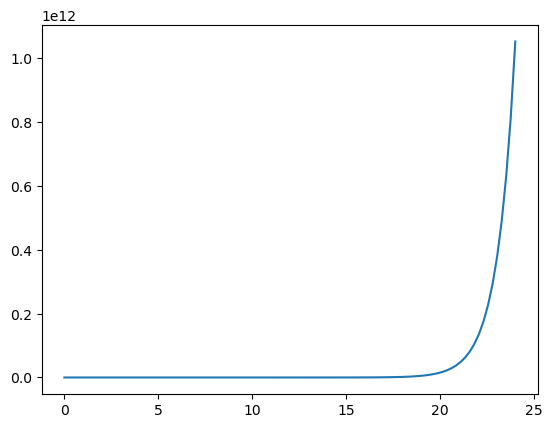

In [23]:
plt.plot(time,simulations[1][:,0])

In [25]:
eval?

Signature: eval(source, globals=None, locals=None, /)
Docstring:
Evaluate the given source in the context of globals and locals.

The source may be a string representing a Python expression
or a code object as returned by compile().
The globals must be a dictionary and locals can be any mapping,
defaulting to the current globals and locals.
If only globals is given, locals defaults to it.
Type:      builtin_function_or_method

In [ ]:
dydt = []
    for j, coeffs in enumerate(coefficients):
        expr = sum(coeff * eval(func, {"y": y, "t": t, "np": np}, {var_name[k]: y[k] for k in range(len(var_name))})
                   for coeff, func in zip(coeffs, function_names))
        dydt.append(expr)

#### Creating the class for learning prior distribution

In [ ]:
def learn_parameter_distribution(data_derivative_matrix, 
                                 library_matrix, mcmc_method='slice', 
                                 dist_type='normal', num_samples=1000):
    try:
        n, m = data_derivative_matrix.shape
        p = library_matrix.shape[1]
    
        # Define the loss function
        def lv_model_resid(params):
            # Reshape params to match the expected dimensions (p, m)
            residuals = data_derivative_matrix - np.dot(library_matrix, params.reshape((p, m)))
            return residuals.flatten()
    
        def log_likelihood(params, sig):
            # print(np.array(params).shape)
            residuals = lv_model_resid(params)
            model = smp.Model()
            # Adding the log-likelihood (residuals following a normal distribution)
            model.add(smp.normal(residuals, mu=np.zeros(len(residuals)), sig=sig))
            # Adding priors for sigma and the parameters
            model.add(smp.exponential(sig))
            # model.add([smp.uniform(param, lower=-2, upper=2) for param in params])  # Adjust bounds as needed
            return model()
    
        # Initial guess for parameters (MAP estimate)
        start_params = np.zeros(p * m)
        start = {'params': start_params, 'sig': 0.1}
    
        # Select the MCMC method
        if mcmc_method == 'slice':
            sampler = smp.Slice(log_likelihood, start)
        elif mcmc_method == 'nuts':
            sampler = smp.Hamiltonian(log_likelihood, start)
        elif mcmc_method == 'metropolis':
            sampler = smp.Metropolis(log_likelihood, start)
        else:
            raise ValueError("Invalid MCMC method specified. Choose from 'slice', 'nuts', or 'metropolis'.")
    
        # Run the sampler
        chain = sampler.sample(num_samples, burn=100)
        print("MCMC sampling complete.")
        print("Chain contents:")
        print(chain)
    
        # Extract the sampled parameters
        sampled_params = np.array(chain['params'])
        sampled_sigma = np.array(chain['sig'])

        print("Sampled parameters shape:", sampled_params.shape)
        print("Sampled parameters:", sampled_params)
    
        # Fit the desired distribution
        if dist_type == 'normal':
            means = np.mean(sampled_params, axis=0)
            stds = np.std(sampled_params, axis=0)
            distribution_params = {'mean': means, 'std': stds}
            print("Distribution parameters (Normal):", distribution_params)
            return distribution_params
        elif dist_type == 'uniform':
            mins = np.min(sampled_params, axis=0)
            maxs = np.max(sampled_params, axis=0)
            distribution_params = {'min': mins, 'max': maxs}
            print("Distribution parameters (Uniform):", distribution_params)
            return distribution_params
        elif dist_type == 'kde':
            kde = KernelDensity(kernel='gaussian').fit(sampled_params)
            print("KDE model created.")
            return kde
        else:
            raise ValueError("Invalid dist_type specified. Choose from 'normal', 'uniform', or 'kde'.")
    
    except Exception as e:
        print(f"An error occurred: {e}")
        raise


In [ ]:
learn_parameter_distribution(data_derivative, library_matrix, mcmc_method='slice', dist_type='normal', num_samples=10)

In [ ]:
def process_arrays(arr1, arr2, tolerance=None):
    """
    Processes two arrays by comparing their corresponding elements.
    
    If the signs of the corresponding elements are different, sets both elements to zero.
    If the absolute difference between the corresponding elements is greater than the tolerance, sets both elements to zero.
    
    If tolerance is not provided, it is set to the maximum absolute difference between the two arrays divided by 2.
    
    Returns the mean of the corresponding elements in the two arrays.
    
    Parameters:
    arr1 (np.ndarray): The first input array.
    arr2 (np.ndarray): The second input array.
    tolerance (float, optional): The tolerance threshold for the absolute difference. If not provided, it is set to max(abs(arr1 - arr2)) / 2.
    
    Returns:
    np.ndarray: An array containing the mean of the corresponding elements from arr1 and arr2.
    """
    # Ensure the arrays have the same shape
    if arr1.shape != arr2.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    # Calculate tolerance if not provided
    if tolerance is None:
        tolerance = np.max(np.abs(arr1 - arr2)) / 2
    
    # Create copies to avoid modifying the original arrays
    arr1_copy = np.copy(arr1)
    arr2_copy = np.copy(arr2)
    
    # Process the arrays
    for i in range(len(arr1)):
        # Check if the signs are different
        if np.sign(arr1_copy[i]) != np.sign(arr2_copy[i]):
            arr1_copy[i] = 0
            arr2_copy[i] = 0
        # Check if the absolute difference exceeds the tolerance
        elif abs(arr1_copy[i] - arr2_copy[i]) > tolerance:
            arr1_copy[i] = 0
            arr2_copy[i] = 0
    
    # Calculate the mean of the corresponding elements
    mean_array = (arr1_copy + arr2_copy)* 1/2
    
    return mean_array

def derive_success_probabilities(prior_matrix, min_prob=0.7):
    """
    Derive success probabilities based on the standard deviation of each column.
    Columns with lower standard deviations get higher probabilities.
    
    If the mean of a column in the prior matrix is less than 0.0001, 
    the success probability for that column is set to 0.05 automatically.
    
    Parameters:
    prior_matrix (np.ndarray): The input prior distribution matrix.
    min_prob (float): The minimum success probability for columns with the highest standard deviation.
    
    Returns:
    np.ndarray: An array of success probabilities for each column.
    """
    std_devs = np.std(prior_matrix, axis=0)
    means = np.mean(prior_matrix, axis=0)
    max_std, min_std = np.max(std_devs), np.min(std_devs)
    
    # Calculate the success probabilities based on standard deviation
    success_probabilities = 1 - (std_devs - min_std) / (max_std - min_std) * (1 - min_prob)
    
    # Adjust success probabilities for columns with mean < 0.0001
    success_probabilities[np.abs(means) < 0.0001] = 0.05
    
    return success_probabilities

def apply_spike_and_slab(prior_matrix, success_probabilities, slab_variance=0.0):
    """
    Apply the Spike-and-Slab prior to generate samples.
    """
    num_samples, num_params = prior_matrix.shape
    samples = np.zeros((num_samples * 10, num_params))
    
    for i in range(num_samples):
        for j in range(10):
            mask = np.random.binomial(1, success_probabilities, num_params)
            slab = np.random.normal(prior_matrix[i], np.sqrt(slab_variance), num_params)
            samples[i * 10 + j] = mask * slab
    return samples

def apply_regularized_horseshoe_with_success(prior_matrix, success_probabilities, horseshoe_scale=0.1):
    """
    Apply the Regularized Horseshoe prior with success probabilities to generate samples.
    
    Parameters:
    prior_matrix (np.ndarray): The input prior distribution matrix.
    success_probabilities (np.ndarray): The success probabilities for each parameter.
    horseshoe_scale (float): The scale parameter for the regularized horseshoe prior.
    
    Returns:
    np.ndarray: A matrix of generated samples.
    """
    num_samples, num_params = prior_matrix.shape
    samples = np.zeros((num_samples * 10, num_params))
    
    for i in range(num_samples):
        for j in range(10):
            # Local shrinkage depends on the success probabilities
            local_shrinkage = np.random.normal(1, horseshoe_scale * success_probabilities, num_params)
            global_shrinkage = np.random.normal(1, horseshoe_scale, 1)
            shrinkage_factors = global_shrinkage * local_shrinkage
            samples[i * 10 + j] = prior_matrix[i] * shrinkage_factors
    return samples

def generate_samples_with_prior(prior_matrix, prior_type='spike_and_slab', success_probabilities=None, 
                                slab_variance=0.01, horseshoe_scale=0.1):
    """
    Generate samples from the specified prior distribution.
    
    Parameters:
    prior_matrix (np.ndarray): The input prior distribution matrix of shape (10000, n).
    prior_type (str): The type of prior to apply ('spike_and_slab' or 'regularized_horseshoe').
    success_probabilities (np.ndarray, optional): The success probabilities for the spike-and-slab prior.
    slab_variance (float, optional): The variance of the slab distribution for spike-and-slab prior.
    horseshoe_scale (float, optional): The scale parameter for the regularized horseshoe prior.
    
    Returns:
    np.ndarray: A matrix of generated samples of shape (100000, n) or the original prior matrix if prior_type is invalid.
    """
    if success_probabilities is None and prior_type == 'spike_and_slab':
        success_probabilities = derive_success_probabilities(prior_matrix)
    
    if prior_type == 'spike_and_slab':
        return apply_spike_and_slab(prior_matrix, success_probabilities, slab_variance)
    elif prior_type == 'regularized_horseshoe':
        # If success probabilities are not provided, use the standard Horseshoe
        if success_probabilities is None:
            success_probabilities = np.ones(prior_matrix.shape[1])
        return apply_regularized_horseshoe_with_success(prior_matrix, success_probabilities, horseshoe_scale)
    else:
        print(f"Invalid prior_type '{prior_type}' specified. Returning the original prior matrix.")
        return prior_matrix

def combine_matrices_and_compute_stats(matrix1, matrix2):
    """
    Combine two matrices, process them to calculate common means, and compute standard deviations.
    
    Parameters:
    matrix1 (np.ndarray): The first input matrix.
    matrix2 (np.ndarray): The second input matrix.
    
    Returns:
    tuple: A tuple containing two arrays - common_means and std_devs.
    """
    if matrix1.shape[-1] != matrix2.shape[-1]:
        raise ValueError("Input matrices must have the same number of columns.")
    
    # Step 1: Compute the means for each column
    means1 = np.mean(matrix1, axis=0)
    means2 = np.mean(matrix2, axis=0)
    
    # Step 2: Use process_arrays function to derive a common mean
    common_means = process_arrays(means1, means2)
    
    # Step 3: Calculate standard deviations
    std_devs = np.zeros(common_means.shape)
    non_zero_mean_indices = common_means != 0

    if np.any(non_zero_mean_indices):
        combined_matrix_non_zero = np.concatenate((matrix1[:, non_zero_mean_indices], matrix2[:, non_zero_mean_indices]), axis=0)
        std_devs[non_zero_mean_indices] = np.std(combined_matrix_non_zero, axis=0)
    
        # Find the smallest standard deviation among the non-zero mean columns
        min_std = np.min(std_devs[non_zero_mean_indices])
    
        # Assign a small standard deviation to columns with zero mean
        std_devs[~non_zero_mean_indices] = min_std / 10
    else:
        # If all means are zero, just assign a small standard deviation
        std_devs.fill(1e-10)
    
    return common_means, std_devs

def learn_prior_distribution_individually(data_derivative, library_matrix, dist_type='Normal'):
    m = data_derivative.shape[1]  # Number of state variables
    p = library_matrix.shape[1]    # Number of library functions
    
    def lv_model_resid(params, data_derivative_vector, library_matrix):
        # Calculate the residual for a single state variable
        residuals = data_derivative_vector - np.dot(library_matrix, params)
        return residuals.flatten()
    
    def compute_sampled_params(params, library_matrix):
        return np.dot(library_matrix, params)
    
    def stls(lv_model_resid, x0, data_derivative_vector, library_matrix, threshold=0.06, max_iter=20):
        params = x0.copy()
        for i in range(max_iter):
            results = least_squares(lv_model_resid, x0=params, args=(data_derivative_vector, library_matrix))
            params = results.x
            params[np.abs(params) < threshold] = 0
        return params

    Means_or_Lower = []
    Std_orUpper = []
    all_chain1=[]
    all_chain2 = []
    
    for i in range(m):
        # Isolate the i-th state variable's derivative and prepare for STLS
        data_derivative_vector = data_derivative[:, i]
        x0 = np.zeros(p)
        
        # Perform STLS for the i-th state variable
        stls_solution = stls(lv_model_resid, x0, data_derivative_vector, library_matrix).round(3)
        
        # Prepare MCMC sampling for the i-th state variable
        mcmc_method = 'nuts'
        num_samples = 50
        start_params = stls_solution
        start = {'params': start_params, 'sig': 0.1}
        
        # Define the log-likelihood function
        def log_likelihood(params, sig):
            y_hat = compute_sampled_params(params, library_matrix)
            residuals = data_derivative_vector - y_hat
            model = smp.Model()
            model.add(smp.normal(residuals, mu=np.zeros(len(residuals)), sig=sig))
            model.add(smp.exponential(sig))
            return model()
        
        # Select and run the MCMC sampler
        if mcmc_method == 'slice':
            sampler = smp.Slice(log_likelihood, start)
        elif mcmc_method == 'nuts':
            sampler = smp.NUTS(log_likelihood, start)
        elif mcmc_method == 'hamiltonian':
            sampler = smp.Hamiltonian(log_likelihood, start)
        elif mcmc_method == 'metropolis':
            sampler = smp.Metropolis(log_likelihood, start)
        else:
            raise ValueError("Invalid MCMC method specified. Choose from 'slice', 'nuts', or 'metropolis'.")
        
        chain1 = sampler.sample(num_samples, burn=int(0.2*num_samples))

       
        # Slice Learning for more samples
        num_samples = 5000
        start = {'params': np.zeros(p), 'sig': 0.1}  # Reset start params for the next sampler
        sampler2 = smp.Slice(log_likelihood, start)
        chain2 = sampler2.sample(num_samples, burn=int(0.2*num_samples))

        print(f"chain1_mean_param{np.mean(chain1['params'],0)}\n")
        print(f"chain2_mean_param{np.mean(chain2['params'],0)}\n")

        print(f"chain1_mean_param{np.std(chain1['params'],0)}\n")
        print(f"chain2_mean_param{np.std(chain2['params'],0)}\n")
        
        # Calculate means and standard deviations or uniform bounds
        common_means, std_devs = combine_matrices_and_compute_stats(chain1['params'], chain2['params'])
        if dist_type == 'Normal':
            Means_or_Lower.append(common_means)
            Std_orUpper.append(std_devs*3)

        elif dist_type == 'Uniform':
            Means_or_Lower.append(common_means - 8 * std_devs)
            Std_orUpper.append(common_means + 8 * std_devs)

        else:
            raise ValueError("Invalid Distribution type. Choose from 'Normal', or 'Uniform'.")
        
        all_chain1.append(chain1)
        all_chain2.append(chain2)
    return all_chain1, all_chain2, Means_or_Lower, Std_orUpper

def learn_prior_distribution(data_derivative, Library_matrix, function_names = None, 
                             dist_type='Normal', num_iter = 5500, threshold_value = 0.05):
    data_derivative_matrix = data_derivative
    library_matrix = Library_matrix
    
    m = data_derivative_matrix.shape[-1]  # Number of state variables
    p = library_matrix.shape[-1]  # Number of functions in the library

    if function_names is None:
        function_names = ['fx'+ str(i+1) + str(j+1) for i in range (m) for j in range(p)]
    # print(function_nm)
    
    # Define the loss function
    def lv_model_resid(params):
        params = np.array(params).reshape(m, p).T
        residuals = data_derivative_matrix - np.dot(library_matrix, params)
        return residuals.flatten()
    
    def compute_sampled_params(params):
        return np.dot(library_matrix, params)
    
    def log_likelihood(params, sigs):
        params = np.array(params).reshape(m, p).T
        y = data_derivative
        y_hat = compute_sampled_params(params)
        model = smp.Model()
        
        # Adding the log-likelihood for each state variable
        for i in range(m):
            model.add(smp.normal(y[:, i], mu=y_hat[:, i], sig=sigs[i]))
        
        # Adding priors for each sigma
        for sig in sigs:
            model.add(smp.exponential(sig))
        
        return model()
        
    start_sigs = np.full(m,0.1)
    
    # Slice Learning
    num_samples = num_iter
    start_params = np.zeros(m * p)
    start = {'params': start_params, 'sigs': start_sigs}
    sampler2 = smp.Slice(log_likelihood, start)
    
    chain2 = sampler2.sample(num_samples, burn=int(0.2 * num_samples))

    
    # NUTS Learning
    def stls(lv_model_resid, x0, threshold=0.06, max_iter=20):
        params = x0.copy()
        for i in range(max_iter):
            results = least_squares(lv_model_resid, x0=params)
            params = results.x
            params[np.abs(params) < threshold] = 0
        return params
    
    x0 = np.zeros(m * p)
    stls_solution = stls(lv_model_resid, x0, threshold=threshold_value).round(3)
    
    zipped_results = list(zip(function_names * m, stls_solution))
    print(zipped_results)
    
    num_samples = int(((num_iter + 3000)/100 - (num_iter/100))/2)
    start_params = stls_solution
    start_sigs = np.full(m, np.mean(chain2.sigs[-100:], 0))  # Initial sigmas for each state variable
    start = {'params': start_params, 'sigs': start_sigs}
    
    mcmc_method = 'nuts'
    if mcmc_method == 'slice':
        sampler = smp.Slice(log_likelihood, start)
    elif mcmc_method == 'nuts':
        sampler = smp.NUTS(log_likelihood, start)
    elif mcmc_method == 'hamiltonian':
        sampler = smp.Hamiltonian(log_likelihood, start)
    elif mcmc_method == 'metropolis':
        sampler = smp.Metropolis(log_likelihood, start)
    else:
        raise ValueError("Invalid MCMC method specified. Choose from 'slice', 'nuts', or 'metropolis'.")
    
    chain1 = sampler.sample(num_samples, burn=int(0.2 * num_samples))
    
    
    common_means, std_devs = combine_matrices_and_compute_stats(chain1['params'], chain2['params'])
    
    if dist_type == 'Normal':
        return chain1, chain2, common_means, std_devs * 3
    elif dist_type == 'Uniform':
        return chain1, chain2, common_means - 8 * std_devs, common_means + 8 * std_devs
    else:
        raise ValueError("Invalid Distribution type. Choose from 'Normal', or 'Uniform'.")

def generate_samples(dist_type, num_samples, param1, param2):
    """
    Generate samples from either a normal or uniform distribution.
    
    Parameters:
    dist_type (str): The type of distribution ('Normal' or 'Uniform').
    num_samples (int): The number of samples to generate.
    param1 (float or np.ndarray): For 'Normal', this is the mean. For 'Uniform', this is the lower bound.
    param2 (float or np.ndarray): For 'Normal', this is the standard deviation. For 'Uniform', this is the upper bound.
    
    Returns:
    np.ndarray: An array of generated samples.
    """
    if dist_type == 'Normal':
        if isinstance(param1, np.ndarray) or isinstance(param2, np.ndarray):
            # If param1 or param2 are vectors, generate samples for each element
            return np.random.normal(loc=param1, scale=param2, size=(num_samples, len(param1)))
        else:
            # If param1 and param2 are scalars, generate scalar samples
            return np.random.normal(loc=param1, scale=param2, size=num_samples)
    
    elif dist_type == 'Uniform':
        if isinstance(param1, np.ndarray) or isinstance(param2, np.ndarray):
            # If param1 or param2 are vectors, generate samples for each element
            return np.random.uniform(low=param1, high=param2, size=(num_samples, len(param1)))
        else:
            # If param1 and param2 are scalars, generate scalar samples
            return np.random.uniform(low=param1, high=param2, size=num_samples)
    
    else:
        raise ValueError("Invalid distribution type. Choose from 'Normal' or 'Uniform'.")

In [ ]:
%%time

chain1, chain2, means, stds = learn_prior_distribution(data_derivative, 
                                                       Library_matrix, 
                                                       function_names, 
                                                       num_iter = 8000, 
                                                       dist_type='Normal')

prior_matrix = generate_samples(dist_type = 'Normal', num_samples = 10000, param1 = means, param2 = std_devs).round(2)

ss_prior_matrix = generate_samples_with_prior(prior_matrix, prior_type='spike_and_slab',
                                              success_probabilities=None, 
                                              slab_variance=0.01, horseshoe_scale=0.1)

In [ ]:
%%time
Prior_generator = Generate_Prior_Distribution(data_derivative, Library_matrix, 
                                              function_names=function_names, 
                                              num_iter=8000, threshold_value=0.05)
Prior_matrix = Prior_generator.generate_prior_distributions()

#### End

# Miscelanuous Code

In [37]:
def confirm_data_structure(data):
    """
    Confirms that the data is in the correct matrix structure, where rows represent time steps
    and columns represent state variables. If not, it transposes the data.
    
    Parameters:
    data (np.ndarray): The input data matrix.
    
    Returns:
    np.ndarray: The correctly structured data matrix.
    """
    # Check if the number of rows is equal to the number of time steps (assume time steps > state variables)
    if data.shape[0] < data.shape[1]:
        # If rows < columns, transpose the matrix
        data = data.T
    
    return data

def confirm_time_length(time_array, data_matrix, time_span=None):
    """
    Confirms that the length of the time array matches the number of rows in the data matrix.
    If not, it generates a new time array that spans the given time_span and fits the number of rows in the data.
    
    Parameters:
    time_array (np.ndarray): The input time array.
    data_matrix (np.ndarray): The input data matrix.
    time_span (tuple, optional): The start and end times for generating a new time array. 
                                 If None, it defaults to (time_array[0], time_array[-1]).
    
    Returns:
    np.ndarray: The confirmed or newly generated time array.
    """
    n_rows = data_matrix.shape[0]
    
    if time_span is None:
        time_span = (time_array[0], time_array[-1])
    
    if len(time_array) != n_rows:
        time_array = np.linspace(time_span[0], time_span[1], n_rows)
    
    return time_array

class SINDyLibraryCreator(ps.SINDy):
    def __init__(self):
        super().__init__()
    
    def compute_library(self, data_matrix, library_type='polynomial', degree=2, 
                        custom_functions=None, specified_library=None, 
                        variable_names=None, include_interaction=True, 
                        include_intercept=True):
        """
        Compute the library of functions from the data.

        Parameters:
        data_matrix (np.ndarray): The input data matrix.
        library_type (str): The type of library to create ('polynomial', 'trigonometry', 'combination', 'custom', 'specified_library').
        degree (int): The degree of the polynomial or the trigonometric library.
        custom_functions (list, optional): A list of custom functions to apply for creating the library.
        specified_library (np.ndarray, optional): A precomputed library provided by the user.
        variable_names (list, optional): A list of variable names corresponding to the state variables.
        include_interaction (bool): Whether to include interaction terms in polynomial libraries.
        include_intercept (bool): Whether to include the intercept term (1) in the library.

        Returns:
        library (np.ndarray): The computed or specified library matrix (n by p).
        function_names (list): The list of function names in the library.

        # Example usage:
        # Assuming `confirmed_matrix` is your data matrix
        library_creator = SINDyLibraryCreator()
        
        # Standard Library with interactions but no intercept
        poly_library, poly_library_names = library_creator.compute_library(
            confirmed_matrix, library_type='polynomial', degree=2, variable_names=['u', 'v'], include_interaction=True, include_intercept=False)
        
        # Standard Library without interactions and without intercept
        poly_no_interaction, poly_no_interaction_names = library_creator.compute_library(
            confirmed_matrix, library_type='polynomial', degree=2, variable_names=['u', 'v'], include_interaction=False, include_intercept=False)
        
        # For custom functions
        custom_funcs = [np.sin, np.cos]
        custom_library_matrix, custom_function_names = library_creator.compute_library(
            confirmed_matrix, library_type='custom', custom_functions=custom_funcs)
        
        # For specified library
        specified_library = np.random.rand(100, 5)  # Example precomputed library
        specified_library_matrix, specified_function_names = library_creator.compute_library(
            confirmed_matrix, library_type='specified_library', specified_library=specified_library)
        
        (custom_library_matrix.shape, custom_function_names), (specified_library_matrix.shape, specified_function_names), (poly_library.shape, poly_library_names)

        """
        n, _ = data_matrix.shape
        
        if variable_names is None:
            variable_names = [f'x{i+1}' for i in range(data_matrix.shape[1])]
        
        # Handling the specified library case
        if library_type == 'specified_library':
            if specified_library is None:
                raise ValueError("Specified library is None, but library_type is 'specified_library'. Please provide a specified library.")
            if specified_library.shape[0] != n:
                raise ValueError("Specified library must have the same number of rows as the data matrix.")
            if custom_functions is None:
                function_names = [f'f{i+1}' for i in range(specified_library.shape[1])]
            else:
                function_names = custom_functions
            
            library = specified_library

        # Handling custom function case
        elif library_type == 'custom':
            if custom_functions is None:
                raise ValueError("Custom functions must be provided when using 'custom' library type.")
            library_matrix = []
            function_names = []
            for func in custom_functions:
                transformed_data = np.apply_along_axis(func, 0, data_matrix)
                library_matrix.append(transformed_data)
                function_names.extend([f"{func.__name__}({var})" for var in variable_names])
            library = np.column_stack(library_matrix)

        # Handling standard library cases
        else:
            if library_type == 'polynomial':
                library = ps.PolynomialLibrary(degree=degree, include_interaction=include_interaction, include_bias=include_intercept)
            elif library_type == 'trigonometry':
                library = ps.FourierLibrary(n_frequencies=degree)
            elif library_type == 'combination':
                library = ps.PolynomialLibrary(degree=degree, include_interaction=include_interaction, include_bias=include_intercept) + ps.FourierLibrary(n_frequencies=degree)
            else:
                raise ValueError("Invalid library type specified.")
            
            # Fit and transform the data to get the library
            library_matrix = library.fit_transform(data_matrix)
            function_names = library.get_feature_names(input_features=variable_names)
            return library_matrix, function_names
        
        # Return the library matrix and function names
        return library, function_names
        
    def compute_derivatives(self, data_matrix, true_parameter=None, 
                            library_matrix=None,
                            differentiation_method=ps.SmoothedFiniteDifference, 
                            smoother_kws=None, order=3, window_length=5):
        """
        Compute the derivatives of the observed data using a specified differentiation method.

        Parameters:
        data_matrix (np.ndarray): The input data matrix (n by m).
        true_parameter (np.ndarray, optional): The true parameters matrix (p by m).
        library_matrix (np.ndarray, optional): The library matrix (n by p). Required if true_parameter is given.
        differentiation_method (class): The differentiation method from pysindy. Default is SmoothedFiniteDifference.
            Other available differentiation methods include:
                - ps.FiniteDifference: Computes derivatives using finite differences.
                - ps.SpectralDerivative: Computes derivatives using spectral methods (FFT).
                - ps.SINDyDerivative: Learns the derivative using SINDy itself.
        smoother_kws (dict, optional): Keyword arguments for the smoother, if applicable.
        order (int): The differentiation order. Default is 3.
        window_length (int): The window length for smoothing. Default is 5.

        Returns:
        data_derivative_matrix (np.ndarray): The matrix of derivatives (n by m).
        """

        n, m = data_matrix.shape
        
        # Check if true_parameter is provided
        if true_parameter is not None:
            if library_matrix is None:
                raise ValueError("Library matrix must be provided if true_parameter is specified.")
            _, p = library_matrix.shape
            if true_parameter.shape != (p, m):
                raise ValueError("True parameter matrix must be of shape (number of library functions, number of state variables).")

        if smoother_kws is None:
            smoother_kws = {'window_length': window_length, 'polyorder': order}

        # Initialize the derivative matrix
        data_derivative_matrix = np.zeros((n, m))

        # Optimize each column individually if true parameters are provided
        for i in range(m):
            if true_parameter is not None:
                def objective_function(params):
                    window_length, order = int(params[0]), int(params[1])
                    smoother_kws = {'window_length': window_length, 'polyorder': order}
                    differentiation_method_instance = differentiation_method(smoother_kws=smoother_kws)
                    derivative = differentiation_method_instance._differentiate(data_matrix[:, i], t=np.arange(n))
                    prediction = np.dot(library_matrix, true_parameter[:, i])
                    mse = np.mean((derivative - prediction) ** 2)
                    return mse

                # Minimize the MSE to find the best window_length and order
                res = minimize(objective_function, [window_length, order], bounds=[(3, 51), (1, 4)], method='Powell')
                optimal_window_length, optimal_order = int(res.x[0]), int(res.x[1])
                print(f'optimize_window_length, optimal_order = {optimal_window_length, optimal_order}')
                smoother_kws = {'window_length': optimal_window_length, 'polyorder': optimal_order}
            else:
                # Use default values
                optimal_window_length, optimal_order = window_length, order

            # Compute the derivative for the current column
            differentiation_method_instance = differentiation_method(smoother_kws=smoother_kws)
            data_derivative_matrix[:, i] = differentiation_method_instance._differentiate(data_matrix[:, i], t=np.arange(n))

        return data_derivative_matrix

class BootstrapClass:
    def __init__(self, data, num_samples=100, bootstrap=True, visualize=True, time=None):
        """
        Initializes the BootstrapClass with the given data and parameters.
        
        Parameters:
        data (np.ndarray): The input data matrix where each column represents a sample path.
        num_samples (int): The number of bootstrap samples to generate for each column.
        bootstrap (bool): Whether to perform bootstrapping. If False, checks data dimensions.
        visualize (bool): Whether to visualize the bootstrap paths. Default is True.
        time (np.ndarray, optional): Time array to use for plotting. Default is None.
        """
        self.data = data
        self.num_samples = num_samples
        self.bootstrap = bootstrap
        self.visualize = visualize
        self.time = time
        self.bootstrap_paths = None

        # Validate the time array if provided
        n_rows, _ = self.data.shape
        if self.time is not None:
            if len(self.time) != n_rows:
                raise ValueError("Time array length must match the number of time instances in the data.")

    def bootstrap_lotka_volterra_column(self, data_column, sample_ratio):
        """
        Bootstraps a single column of the Lotka-Volterra predator-prey population data.
        """
        n = len(data_column)  # Number of time instances
        indices = np.arange(1, n - 1)  # Create index array from 1 to n-1

        # Bootstrap sample indices (without replacement, random proportion of original)
        boot_indices = resample(indices, replace=False, n_samples=int(sample_ratio * len(indices)))
        boot_indices = np.sort(boot_indices)  # Sort indices for slicing

        # Add the first and last index
        boot_indices = np.insert(boot_indices, 0, 0)  # Add index 0 at the start
        boot_indices = np.append(boot_indices, n - 1)  # Add index n-1 at the end

        # Extract corresponding sampled data
        sampled_data = data_column[boot_indices]

        # Create new time points to interpolate to (original number of points)
        new_time_points = np.linspace(0, n - 1, n)

        # Interpolate sampled data to new time points
        interpolate_data = interp1d(boot_indices, sampled_data, kind='linear', fill_value="extrapolate")

        # Generate new interpolated data
        new_data_population = interpolate_data(new_time_points)

        return new_data_population

    def generate_bootstrap_paths(self):
        """
        Generates bootstrap paths for the input data matrix or checks dimensions if bootstrap is False.
        
        Returns:
        np.ndarray: A 3D array of shape (p, m, n) where p is the number of state variables,
                    n is the number of time instances, and m is the number of bootstrapped samples.
        """
        n_rows, n_cols = self.data.shape

        if self.bootstrap:
            # Initialize the output array to hold bootstrap samples
            self.bootstrap_paths = np.zeros((n_cols, self.num_samples, n_rows))

            for col in range(n_cols):
                for i in range(self.num_samples):
                    # Randomly select the proportion of data points to use
                    sample_ratio = np.random.uniform(0.6, 0.95)

                    # Generate a bootstrap sample for the current column
                    self.bootstrap_paths[col, i, :] = self.bootstrap_lotka_volterra_column(self.data[:, col], sample_ratio)

            if self.visualize:
                self.visualize_bootstrap_paths()
            
            # Reorder dimensions to (p, m, n) where p is the number of state variables
            return self.bootstrap_paths
        else:
            # Check the dimensions if bootstrapping is not performed
            if n_cols > 1 and self.data.ndim != 3:
                raise ValueError("For multiple state variables, the data matrix should be 3D (p x m x n).")
            elif n_cols == 1 and self.data.ndim != 2:
                raise ValueError("For a single state variable, the data matrix should be 2D (p x n).")
            return self.data

    def visualize_bootstrap_paths(self, num_samples_to_plot=None):
        """
        Visualizes the bootstrapped paths for each state variable.
        
        Parameters:
        num_samples_to_plot (int, optional): The number of bootstrap samples to plot for each state variable.
                                             If None, all bootstrapped paths will be plotted.
        """
        if self.bootstrap_paths is None:
            raise ValueError("Bootstrap paths not generated. Please generate them first.")

        p, m, n = self.bootstrap_paths.shape
        time_points = self.time if self.time is not None else np.arange(n)

        # If num_samples_to_plot is None, plot all bootstrapped paths
        num_samples_to_plot = m if num_samples_to_plot is None else min(num_samples_to_plot, m)

        for state_var in range(p):
            plt.figure(figsize=(10, 6))
            # Plot the bootstrapped paths
            for i in range(num_samples_to_plot):
                plt.plot(time_points, self.bootstrap_paths[state_var, i, :], alpha=0.4, label=f'Bootstrap Sample {i+1}')

            # Plot the original data for reference
            plt.plot(time_points, self.data[:, state_var], 'k-', lw=2, label='Original Data')

            plt.xlabel('Time')
            plt.ylabel(f'State Variable {state_var + 1}')
            plt.title(f'Bootstrapped Paths for State Variable {state_var + 1}')
            # plt.legend(loc='upper right', fontsize='small')
            plt.grid(True)
            plt.show()

optimize_window_length, optimal_order = (5, 2)
optimize_window_length, optimal_order = (5, 3)


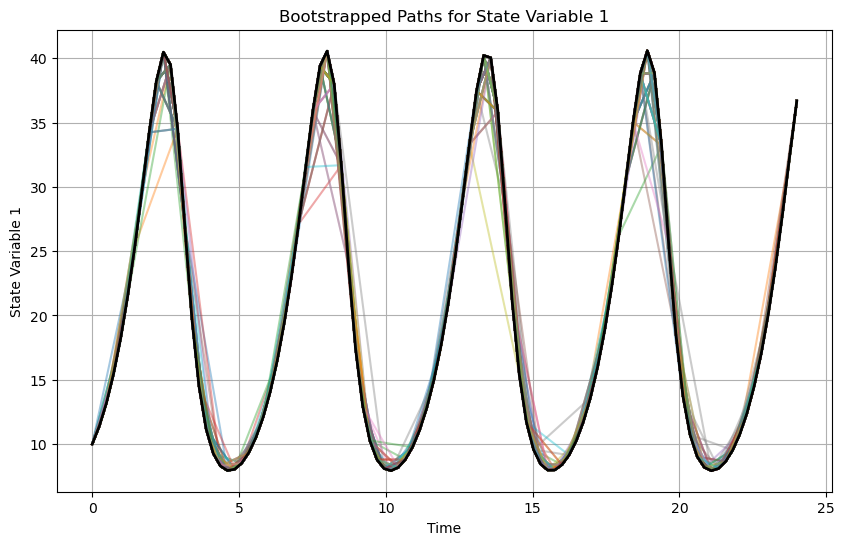

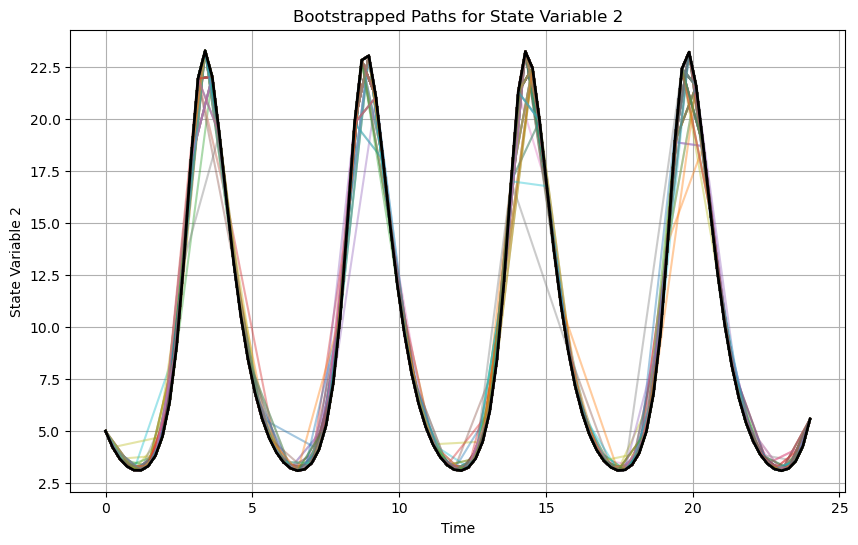

(2, 200, 100)


In [40]:
# Example usage with generated Lotka-Volterra data
data_matrix = np.column_stack([u, v])
confirmed_matrix = confirm_data_structure(data_matrix)

confirmed_matrix.shape  # Check the shape to ensure it's correctly structured

# Example usage with the confirmed data matrix
confirmed_time = confirm_time_length(t, confirmed_matrix, time_span=(0, 24))

confirmed_time.shape, confirmed_time[:5]  # Check the shape and first few values
# Assuming `confirmed_matrix` is your data matrix
library_creator = SINDyLibraryCreator()

# Standard Library with interactions but no intercept
poly_library, poly_library_names = library_creator.compute_library(
    confirmed_matrix, library_type='polynomial', degree=2, variable_names=['u', 'v'], include_interaction=True, include_intercept=True)

# Standard Library without interactions and without intercept
poly_no_interaction, poly_no_interaction_names = library_creator.compute_library(
    confirmed_matrix, library_type='polynomial', degree=2, variable_names=['u', 'v'], include_interaction=False, include_intercept=False)

# For custom functions
custom_funcs = [np.sin, np.cos]
custom_library_matrix, custom_function_names = library_creator.compute_library(
    confirmed_matrix, library_type='custom', custom_functions=custom_funcs)

# For specified library
specified_library = np.random.rand(100, 5)  # Example precomputed library
specified_library_matrix, specified_function_names = library_creator.compute_library(
    confirmed_matrix, library_type='specified_library', specified_library=specified_library)

(custom_library_matrix.shape, custom_function_names), (specified_library_matrix.shape, specified_function_names), (poly_library.shape, poly_library_names)

# Example usage
library_creator = SINDyLibraryCreator()

# Compute the derivatives without true parameters (uses default values)
data_derivatives = library_creator.compute_derivatives(confirmed_matrix)

# Compute the derivatives with true parameters (requires library matrix)
true_parameter_matrix = np.array([[0, 1, 0, 0, -0.1, 0],[0, 0,-1.5, 0, 0.075, 0]]).T  # Provide the true parameters here
data_derivatives_optimized = library_creator.compute_derivatives(
    confirmed_matrix, 
    true_parameter=true_parameter_matrix, 
    library_matrix=poly_library
)

# Example usage:
data = confirmed_matrix  # Replace with your actual data
time_array = np.linspace(0, 24, data.shape[0])  # Example time array

bootstrap_class = BootstrapClass(data, num_samples=200, bootstrap=True, visualize=True, time=time_array)
bootstrap_paths = bootstrap_class.generate_bootstrap_paths()

# Check the shape of the bootstrap paths (should be p, m, n)
print(bootstrap_paths.shape)  # Should print (2, 200, 100) for 2 states, 200 samples, 100 time points
